# Predicting wild fires in California based on Environmental Conditions 🌲🔥

### 1. Importing dependencies

In [1]:
import pandas as pd
from math import pi
import re
from io import StringIO
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score

### 2. Visualizing data

Loading data:

In [2]:
# Read the ARFF file manually
with open("./california-environmental-conditions-dataset.arff", 'r') as f:
    lines = f.readlines()

# Find where @DATA starts
data_start = 0
for i, line in enumerate(lines):
    if line.strip().upper() == '@DATA':
        data_start = i + 1
        break

# Extract column names from @ATTRIBUTE lines
columns = []
for line in lines:
    if line.strip().startswith('@ATTRIBUTE'):
        # Extract attribute name (handle quoted names and names with parentheses)
        match = re.search(r'@ATTRIBUTE\s+(".*?"|\S+)\s+', line, re.IGNORECASE)
        if match:
            col_name = match.group(1).strip('"')
            columns.append(col_name)

# Read data section into DataFrame
data_lines = [line.strip() for line in lines[data_start:] if line.strip()]

# Define data types for each column
dtype_dict = {
    'Stn_Id': 'int64',
    'Stn_Name': 'str',
    'CIMIS_Region': 'str',
    'Date': 'str',
    'ETo_(in)': 'float64',
    'Precip_(in)': 'float64',
    'Sol_Rad_(Ly/day)': 'float64',
    'Avg_Vap_Pres_(mBars)': 'float64',
    'Max_Air_Temp_(F)': 'float64',
    'Min_Air_Temp_(F)': 'float64',
    'Avg_Air_Temp_(F)': 'float64',
    'Max_Rel_Hum_(%)': 'float64',
    'Min_Rel_Hum_(%)': 'float64',
    'Avg_Rel_Hum_(%)': 'float64',
    'Dew_Point_(F)': 'float64',
    'Avg_Wind_Speed_(mph)': 'float64',
    'Wind_Run_(miles)': 'float64',
    'Avg_Soil_Temp_(F)': 'float64',
    'Target': 'int64'
}

# Parse CSV-like data (handling quotes and missing values marked as '?')
data_str = '\n'.join(data_lines)
df = pd.read_csv(
    StringIO(data_str),
    names=columns,
    quotechar="'",
    escapechar='\\',
    dtype=dtype_dict,na_values='?',
    low_memory=False
    )

print(f"Data loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
df.head()

Data loaded successfully: 128125 rows, 19 columns


,Stn_Id,Stn_Name,CIMIS_Region,Date,ETo_(in),Precip_(in),Sol_Rad_(Ly/day),Avg_Vap_Pres_(mBars),Max_Air_Temp_(F),Min_Air_Temp_(F),Avg_Air_Temp_(F),Max_Rel_Hum_(%),Min_Rel_Hum_(%),Avg_Rel_Hum_(%),Dew_Point_(F),Avg_Wind_Speed_(mph),Wind_Run_(miles),Avg_Soil_Temp_(F),Target
0,2,FivePoints,San Joaquin Valley,1/1/2018,0.06,0.00,219.0,7.3,63.4,35.3,47.8,82.0,46.0,65.0,36.6,3.3,78.3,51.1,0
1,2,FivePoints,San Joaquin Valley,1/2/2018,0.04,0.00,127.0,7.4,59.8,37.7,47.2,80.0,52.0,67.0,36.7,3.1,74.5,51.3,0
2,2,FivePoints,San Joaquin Valley,1/3/2018,0.04,0.00,125.0,8.4,61.1,37.3,49.9,79.0,49.0,68.0,39.9,4.5,107.5,51.3,0
3,2,FivePoints,San Joaquin Valley,1/4/2018,0.07,0.01,219.0,11.6,69.2,48.7,56.8,94.0,52.0,74.0,48.5,5.8,140.2,53.0,0
4,2,FivePoints,San Joaquin Valley,1/5/2018,0.07,0.00,239.0,12.7,73.8,47.5,59.8,94.0,49.0,72.0,50.8,4.2,101.4,54.4,0


Data insights/visualization:

In [3]:
# Human-readable descriptions based on dataset metadata
description_map = {
    'Target': 'Binary target indicating whether a fire occurred (0 = no, 1 = yes)',

    'Stn_Id': 'CIMIS station ID (numeric identifier for weather station)',
    'Stn_Name': 'Weather station name',
    'CIMIS_Region': 'CIMIS region name',

    'Date': 'Observation date (MM/DD/YYYY)',

    'ETo_(in)': 'Reference evapotranspiration in inches',
    'Precip_(in)': 'Precipitation in inches',

    'Sol_Rad_(Ly/day)': 'Solar radiation (Ly/day)',

    'Avg_Vap_Pres_(mBars)': 'Average vapor pressure in mBars',

    'Max_Air_Temp_(F)': 'Maximum air temperature (°F)',
    'Min_Air_Temp_(F)': 'Minimum air temperature (°F)',
    'Avg_Air_Temp_(F)': 'Average air temperature (°F)',

    'Max_Rel_Hum_(%)': 'Maximum relative humidity (%)',
    'Min_Rel_Hum_(%)': 'Minimum relative humidity (%)',
    'Avg_Rel_Hum_(%)': 'Average relative humidity (%)',

    'Dew_Point_(F)': 'Dew point temperature (°F)',
    'Avg_Wind_Speed_(mph)': 'Average wind speed (mph)',
    'Wind_Run_(miles)': 'Wind run (miles) — cumulative distance traveled by wind',

    'Avg_Soil_Temp_(F)': 'Average soil temperature (°F)'
}

summary = []
for col in df.columns:

    # Getting col
    col_series = df[col]

    # Getting col properties
    dtype = str(col_series.dtype)
    distinct = int(col_series.nunique(dropna=True))
    missing = int(col_series.isnull().sum())

    # Showing examples
    examples = list(pd.Series(col_series.dropna().unique()).astype(str)[:3])
    examples_str = "<><>".join(examples) if examples else ""
    description = description_map.get(col, "NO DESCRIPTION FOUND")

    # Building the list
    summary.append({
        'column': col,
        'dtype': dtype,
        'distinct_values': distinct,
        'missing': missing,
        'examples': examples_str,
        'description': description
    })

# Converting list to DataFrame
summary_df = pd.DataFrame(summary)

# Numeric columns
numeric_cols = df.select_dtypes(include=['number'])
numeric_cols_list = numeric_cols.columns.tolist()
print(f"Numeric columns ({len(numeric_cols_list)}): {numeric_cols_list}")

# Non-numeric columns  
non_numeric_cols = df.select_dtypes(exclude=['number'])
non_numeric_cols_list = non_numeric_cols.columns.tolist()
print(f"Non-numeric columns ({len(non_numeric_cols_list)}): {non_numeric_cols_list}")

# Displaying DataFrame
summary_df

Numeric columns (16): ['Stn_Id', 'ETo_(in)', 'Precip_(in)', 'Sol_Rad_(Ly/day)', 'Avg_Vap_Pres_(mBars)', 'Max_Air_Temp_(F)', 'Min_Air_Temp_(F)', 'Avg_Air_Temp_(F)', 'Max_Rel_Hum_(%)', 'Min_Rel_Hum_(%)', 'Avg_Rel_Hum_(%)', 'Dew_Point_(F)', 'Avg_Wind_Speed_(mph)', 'Wind_Run_(miles)', 'Avg_Soil_Temp_(F)', 'Target']
Non-numeric columns (3): ['Stn_Name', 'CIMIS_Region', 'Date']


,column,dtype,distinct_values,missing,examples,description
0,Stn_Id,int64,153,0,2<><>5<><>6,CIMIS station ID (numeric identifier for weath...
1,Stn_Name,object,153,0,FivePoints<><>Shafter<><>Davis,Weather station name
2,CIMIS_Region,object,14,0,San Joaquin Valley<><>Sacramento Valley<><>Sie...,CIMIS region name
3,Date,object,991,0,1/1/2018<><>1/2/2018<><>1/3/2018,Observation date (MM/DD/YYYY)
4,ETo_(in),float64,50,83,0.06<><>0.04<><>0.07,Reference evapotranspiration in inches
5,Precip_(in),float64,312,0,0.0<><>0.01<><>0.04,Precipitation in inches
6,Sol_Rad_(Ly/day),float64,976,0,219.0<><>127.0<><>125.0,Solar radiation (Ly/day)
7,Avg_Vap_Pres_(mBars),float64,333,0,7.3<><>7.4<><>8.4,Average vapor pressure in mBars
8,Max_Air_Temp_(F),float64,922,3,63.4<><>59.8<><>61.1,Maximum air temperature (°F)
9,Min_Air_Temp_(F),float64,884,1,35.3<><>37.7<><>37.3,Minimum air temperature (°F)


In [4]:
df.describe()

,Stn_Id,ETo_(in),Precip_(in),Sol_Rad_(Ly/day),Avg_Vap_Pres_(mBars),Max_Air_Temp_(F),Min_Air_Temp_(F),Avg_Air_Temp_(F),Max_Rel_Hum_(%),Min_Rel_Hum_(%),Avg_Rel_Hum_(%),Dew_Point_(F),Avg_Wind_Speed_(mph),Wind_Run_(miles),Avg_Soil_Temp_(F),Target
count,128125.000000,128042.000000,128125.000000,128125.000000,128125.000000,128122.000000,128124.000000,128120.000000,128125.000000,128125.000000,128112.000000,128112.000000,128125.000000,128125.000000,128105.000000,128125.000000
mean,157.257686,0.157898,0.038263,458.957136,11.285094,75.279722,48.495665,61.185965,85.018100,40.166431,61.374438,45.939090,4.314043,103.532969,62.799889,0.041787
std,72.576703,0.086695,0.202978,198.349566,4.105851,14.742913,11.430017,12.386885,16.407883,20.678380,20.273168,10.927562,2.041915,48.999902,10.672439,0.200104
min,2.000000,0.000000,0.000000,0.000000,0.000000,24.900000,-5.000000,13.000000,0.000000,0.000000,0.000000,-74.300000,0.700000,16.200000,31.500000,0.000000
25%,99.000000,0.080000,0.000000,301.000000,8.400000,64.000000,41.100000,52.800000,78.000000,23.000000,46.000000,40.000000,3.000000,71.600000,54.400000,0.000000
50%,171.000000,0.150000,0.000000,471.000000,11.200000,74.300000,48.800000,60.100000,91.000000,37.000000,63.000000,47.500000,3.800000,92.300000,62.900000,0.000000
75%,219.000000,0.230000,0.000000,633.000000,14.000000,86.100000,55.800000,69.200000,97.000000,55.000000,78.000000,53.600000,5.100000,122.400000,70.800000,0.000000
max,262.000000,0.490000,13.610000,6618.000000,39.700000,123.700000,93.400000,106.500000,100.000000,100.000000,100.000000,82.200000,46.900000,1125.300000,96.900000,1.000000


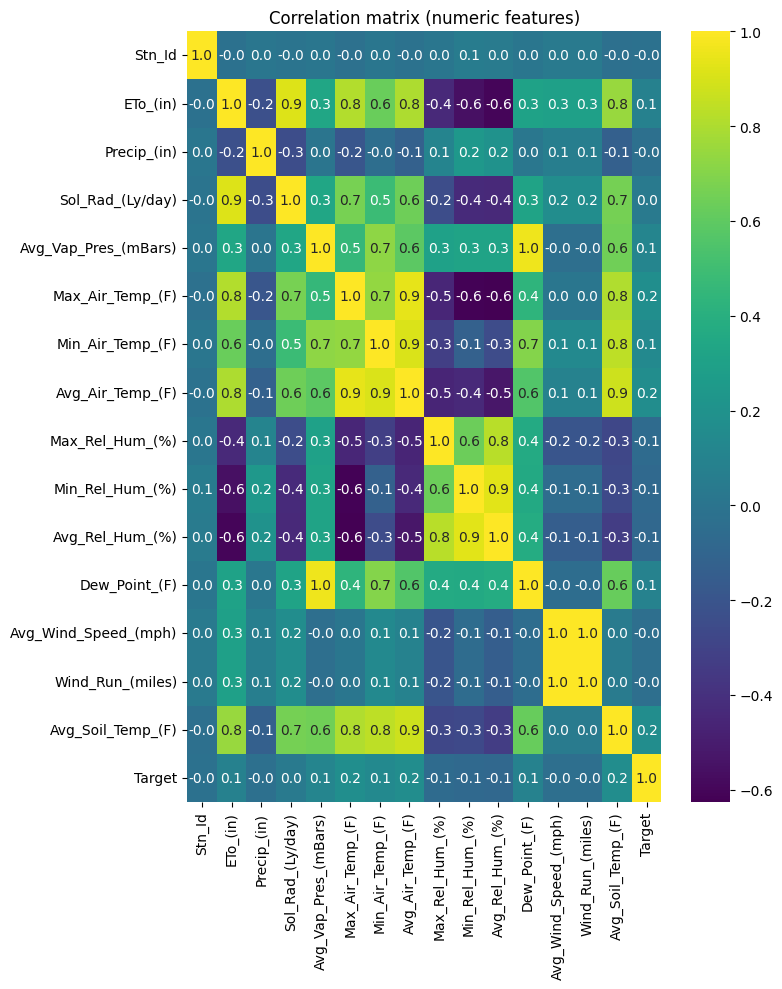

In [5]:
# Compute correlation
corr = df.select_dtypes(include=["number"]).corr()

plt.figure(figsize=(8, 10))
sns.heatmap(corr, annot=True, cmap='viridis', fmt='.1f')
plt.title('Correlation matrix (numeric features)')
plt.tight_layout()
plt.show()

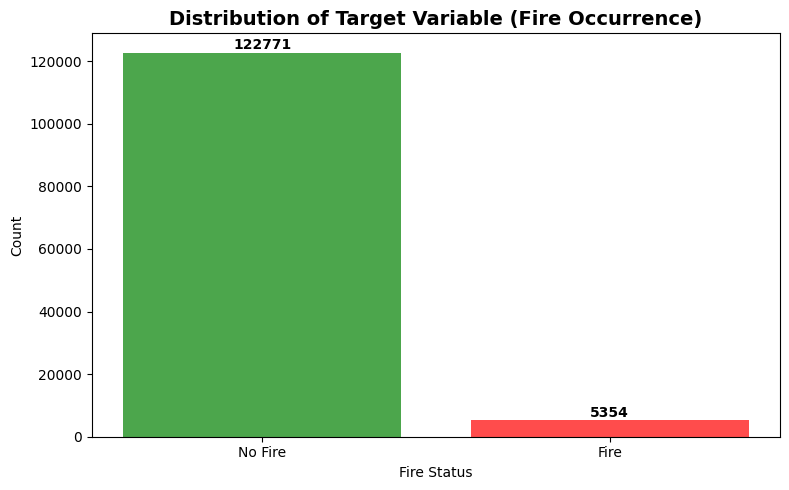

No Fire (0): 122771 (95.82%)
Fire (1): 5354 (4.18%)


In [6]:
# Distribution of target variable
plt.figure(figsize=(8, 5))
target_counts = df["Target"].value_counts()
plt.bar(['No Fire', 'Fire'], target_counts.values, color=['green', 'red'], alpha=0.7)
plt.title('Distribution of Target Variable (Fire Occurrence)', fontsize=14, fontweight='bold')
plt.ylabel('Count')
plt.xlabel('Fire Status')
for i, v in enumerate(target_counts.values):
    plt.text(i, v + 1000, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

print(f"No Fire (0): {target_counts[0]} ({target_counts[0]/len(df["Target"])*100:.2f}%)")
print(f"Fire (1): {target_counts[1]} ({target_counts[1]/len(df["Target"])*100:.2f}%)")

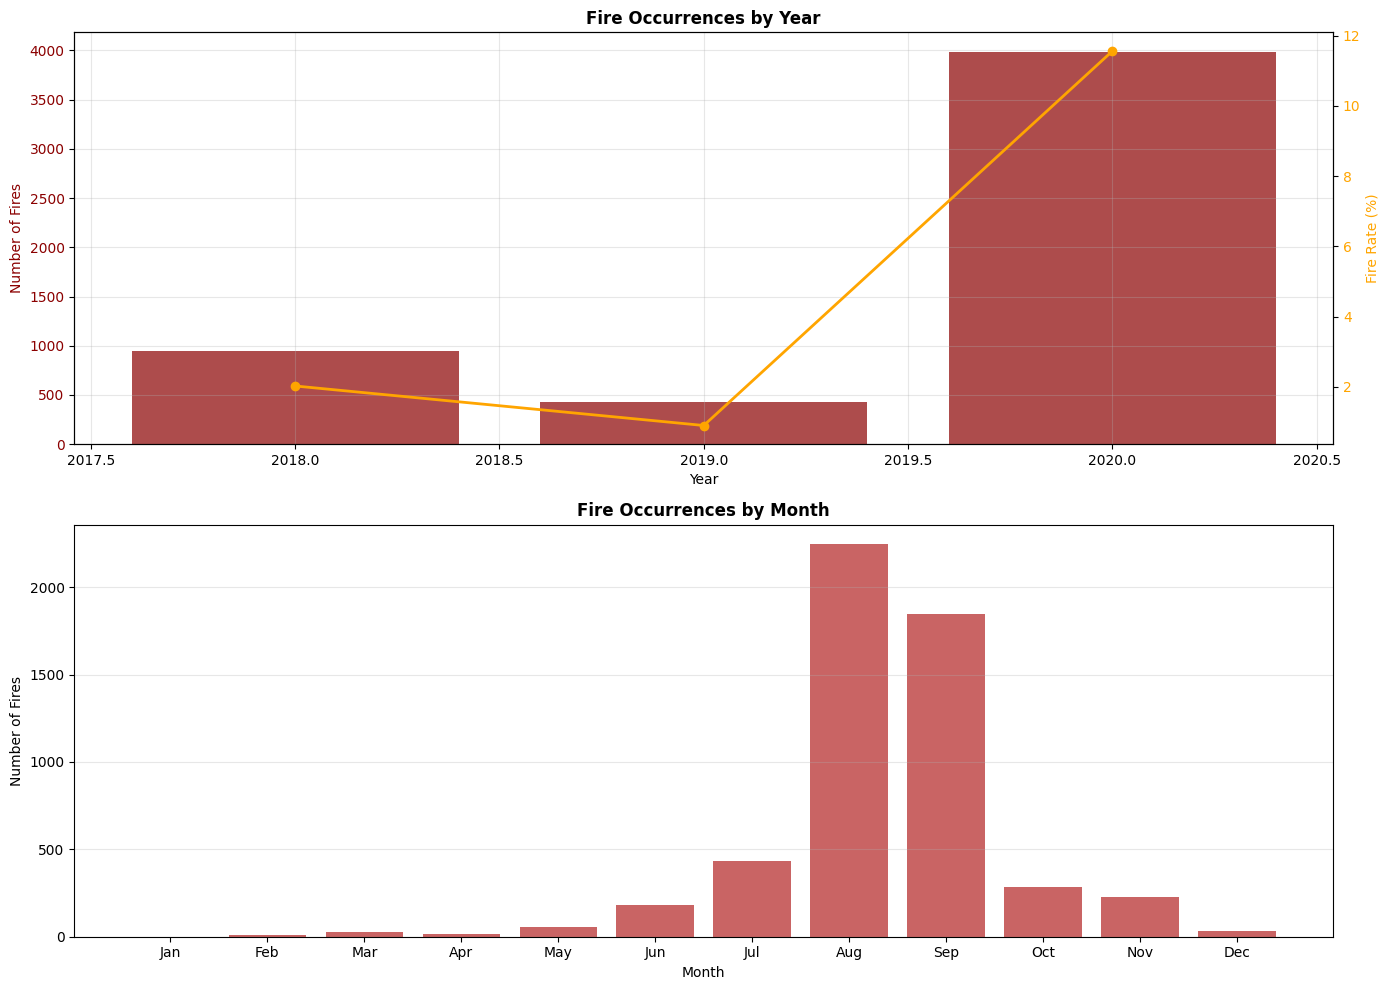

In [7]:
# Time series: Convert date and analyze temporal patterns
df['Date_parsed'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df['Year'] = df['Date_parsed'].dt.year
df['Month'] = df['Date_parsed'].dt.month

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Fire occurrences by year
yearly_fires = df.groupby('Year')['Target'].agg(['sum', 'count'])
yearly_fires['fire_rate'] = (yearly_fires['sum'] / yearly_fires['count'] * 100)

axes[0].bar(yearly_fires.index, yearly_fires['sum'], color='darkred', alpha=0.7, label='Fire Count')
ax2 = axes[0].twinx()
ax2.plot(yearly_fires.index, yearly_fires['fire_rate'], color='orange', marker='o', linewidth=2, label='Fire Rate (%)')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Fires', color='darkred')
ax2.set_ylabel('Fire Rate (%)', color='orange')
axes[0].set_title('Fire Occurrences by Year', fontsize=12, fontweight='bold')
axes[0].tick_params(axis='y', labelcolor='darkred')
ax2.tick_params(axis='y', labelcolor='orange')
axes[0].grid(alpha=0.3)

# Fire occurrences by month
monthly_fires = df.groupby('Month')['Target'].agg(['sum', 'count'])
monthly_fires['fire_rate'] = (monthly_fires['sum'] / monthly_fires['count'] * 100)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

axes[1].bar(range(1, 13), monthly_fires['sum'], color='firebrick', alpha=0.7)
axes[1].set_xticks(range(1, 13))
axes[1].set_xticklabels(month_names)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Number of Fires')
axes[1].set_title('Fire Occurrences by Month', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

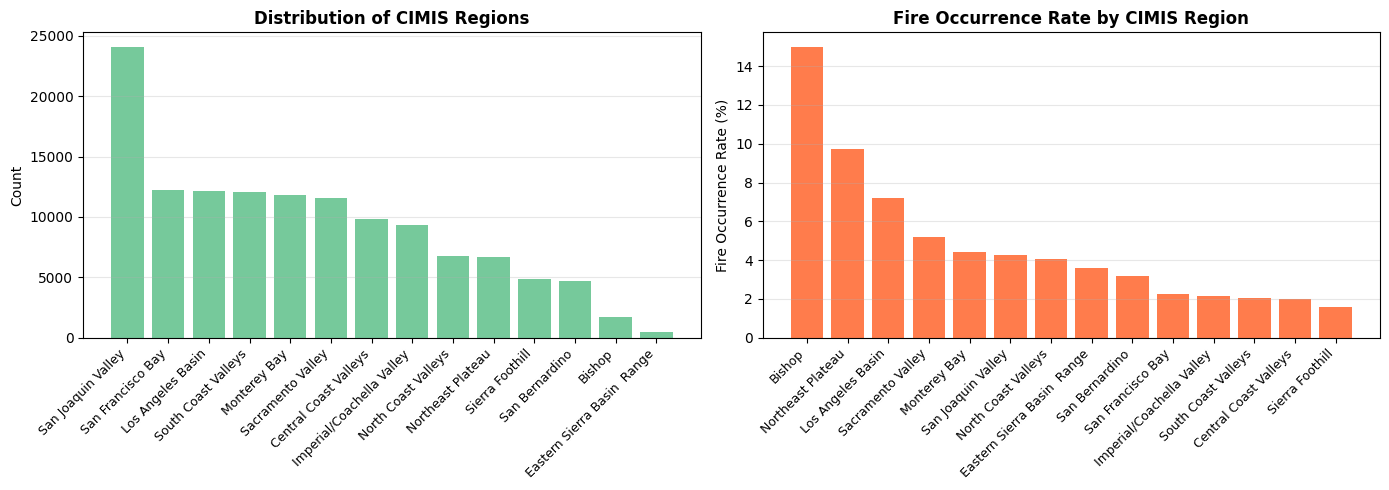

In [8]:
# Non-numeric features: CIMIS Regions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Region distribution
region_counts = df['CIMIS_Region'].value_counts()
axes[0].bar(range(len(region_counts)), region_counts.values, color='mediumseagreen', alpha=0.7)
axes[0].set_xticks(range(len(region_counts)))
axes[0].set_xticklabels(region_counts.index, rotation=45, ha='right', fontsize=9)
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of CIMIS Regions', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')

# Fire occurrence by region
region_fire = df.groupby('CIMIS_Region')['Target'].agg(['sum', 'count'])
region_fire['fire_rate'] = (region_fire['sum'] / region_fire['count'] * 100)
region_fire = region_fire.sort_values('fire_rate', ascending=False)

axes[1].bar(range(len(region_fire)), region_fire['fire_rate'].values, color='orangered', alpha=0.7)
axes[1].set_xticks(range(len(region_fire)))
axes[1].set_xticklabels(region_fire.index, rotation=45, ha='right', fontsize=9)
axes[1].set_ylabel('Fire Occurrence Rate (%)')
axes[1].set_title('Fire Occurrence Rate by CIMIS Region', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

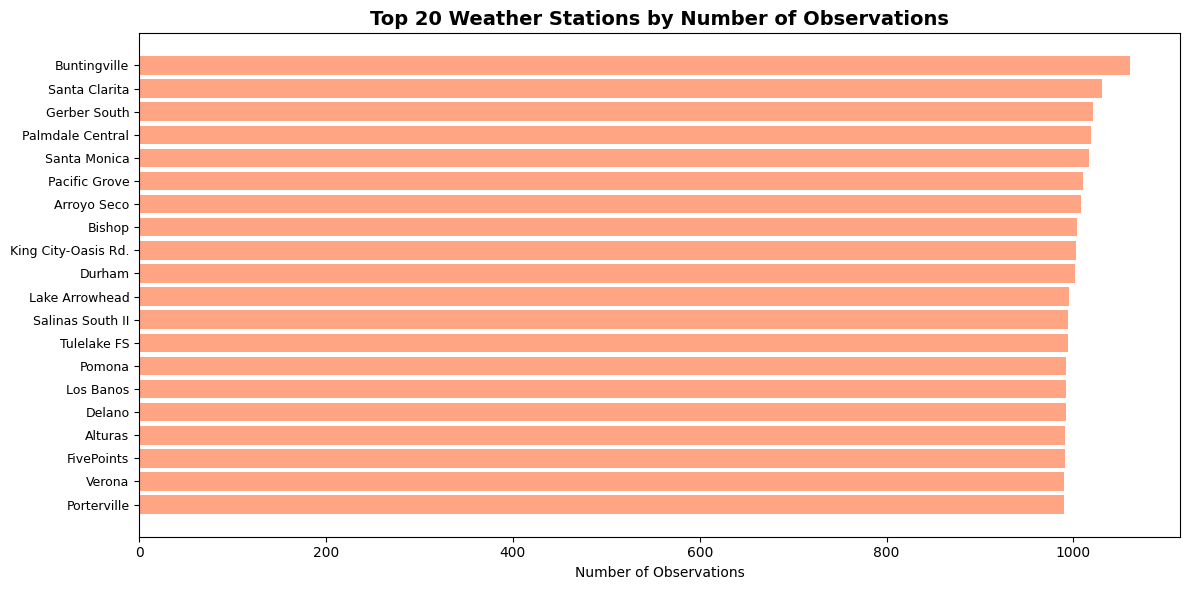

In [9]:
# Non-numeric features: Station Names
plt.figure(figsize=(12, 6))
station_counts = df['Stn_Name'].value_counts().head(20)
plt.barh(range(len(station_counts)), station_counts.values, color='coral', alpha=0.7)
plt.yticks(range(len(station_counts)), station_counts.index, fontsize=9)
plt.xlabel('Number of Observations')
plt.title('Top 20 Weather Stations by Number of Observations', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

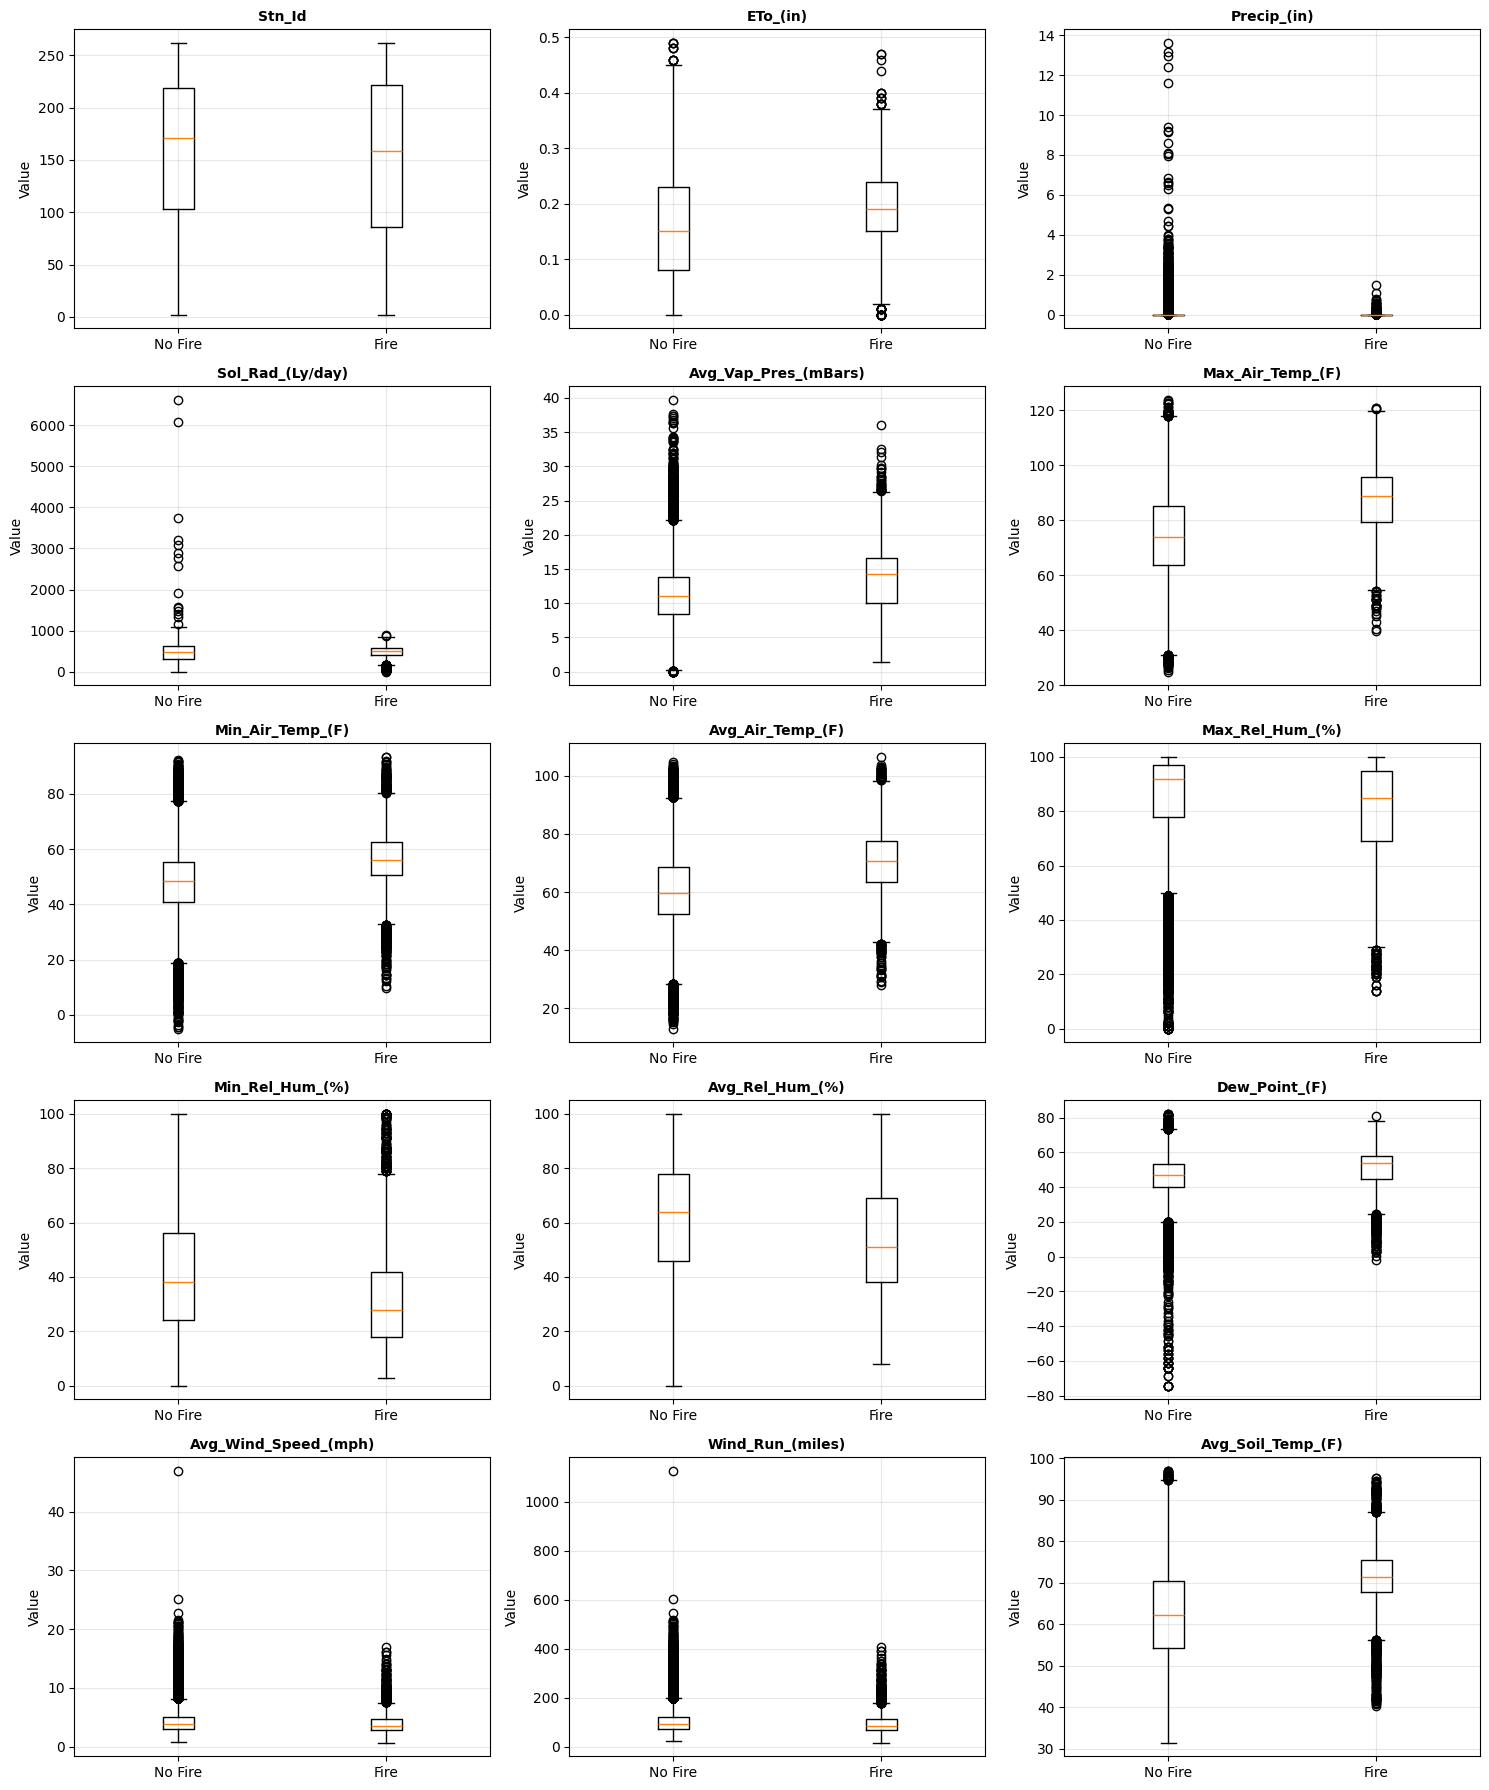

In [10]:
# Box plots for numeric features by target
fig, axes = plt.subplots(5, 3, figsize=(15, 18))
axes = axes.ravel()

# Exclude 'Target' from features to plot since we're grouping by Target
numeric_features = [col for col in numeric_cols.columns.tolist() if col != 'Target']

for idx, col in enumerate(numeric_features):
    data_to_plot = [df[df['Target'] == 0][col].dropna(), df[df['Target'] == 1][col].dropna()]
    axes[idx].boxplot(data_to_plot, tick_labels=['No Fire', 'Fire'])
    axes[idx].set_title(col, fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Value')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

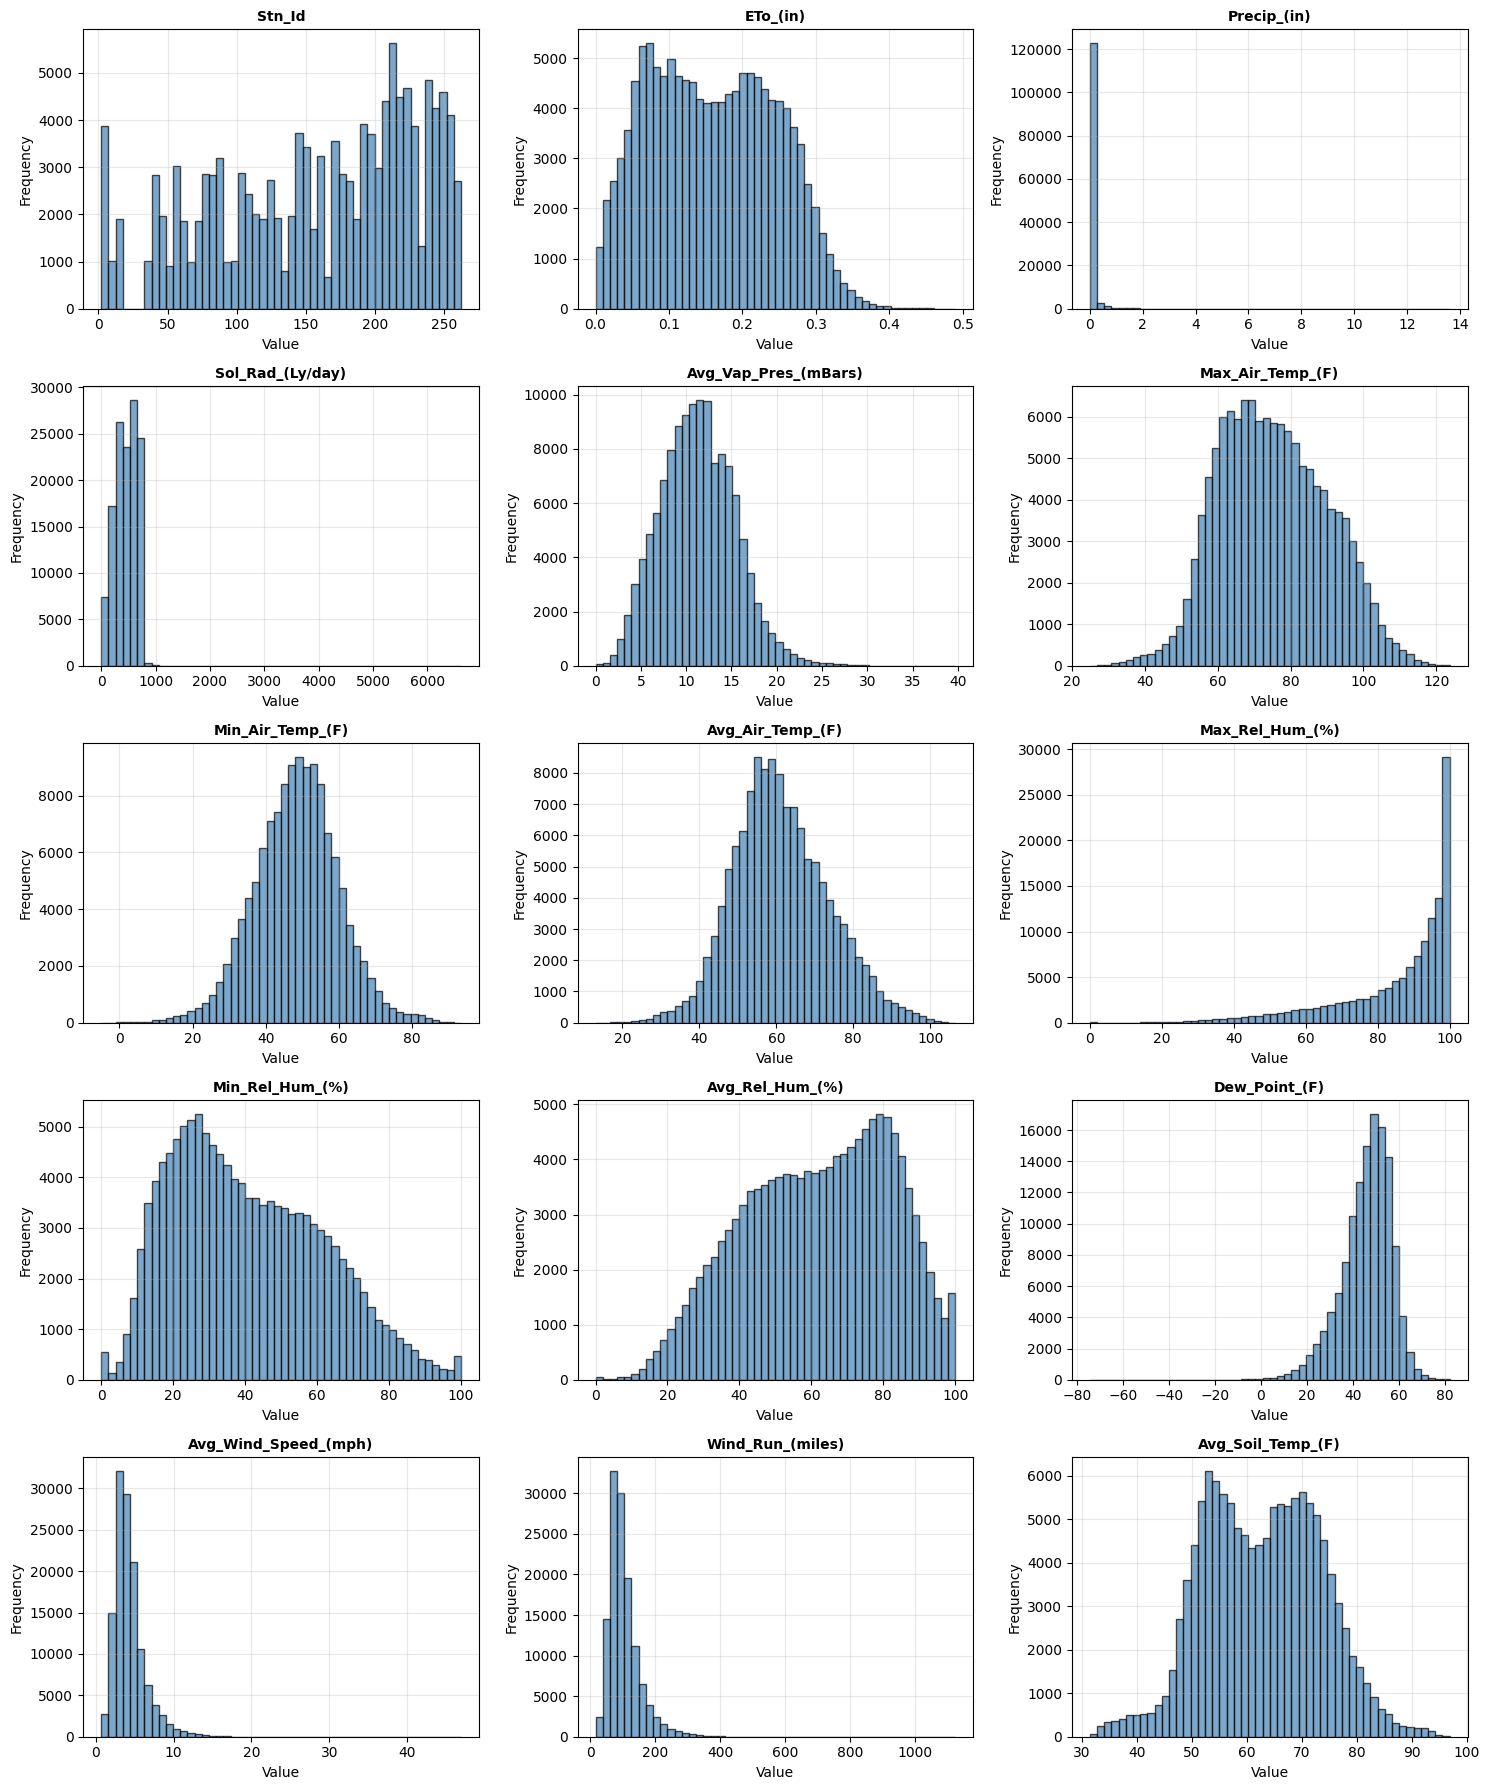

In [11]:
# Distribution of numeric features
fig, axes = plt.subplots(5, 3, figsize=(15, 18))
axes = axes.ravel()

# Exclude 'Target' from features to plot since we're grouping by Target
numeric_features = [col for col in numeric_cols.columns.tolist() if col != 'Target']

for idx, col in enumerate(numeric_features):
    axes[idx].hist(df[col].dropna(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
    axes[idx].set_title(col, fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Find features with high correlation (> 0.5 or < -0.5)
# Get correlation matrix
corr_matrix = numeric_cols.corr()

# Find pairs with high correlation (excluding diagonal)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.5:
            high_corr_pairs.append({
                'feature1': corr_matrix.columns[i],
                'feature2': corr_matrix.columns[j],
                'correlation': corr_matrix.iloc[i, j]
            })

# Display high correlation pairs
high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False, key=abs)
print(f"Found {len(high_corr_df)} feature pairs with |correlation| > 0.5:\n")
high_corr_df

Found 30 feature pairs with |correlation| > 0.5:



,feature1,feature2,correlation
29,Avg_Wind_Speed_(mph),Wind_Run_(miles),0.999900
12,Avg_Vap_Pres_(mBars),Dew_Point_(F),0.958162
15,Max_Air_Temp_(F),Avg_Air_Temp_(F),0.939359
27,Min_Rel_Hum_(%),Avg_Rel_Hum_(%),0.926691
0,ETo_(in),Sol_Rad_(Ly/day),0.912283
19,Min_Air_Temp_(F),Avg_Air_Temp_(F),0.905173
24,Avg_Air_Temp_(F),Avg_Soil_Temp_(F),0.875567
21,Min_Air_Temp_(F),Avg_Soil_Temp_(F),0.840396
26,Max_Rel_Hum_(%),Avg_Rel_Hum_(%),0.827034
1,ETo_(in),Max_Air_Temp_(F),0.814440


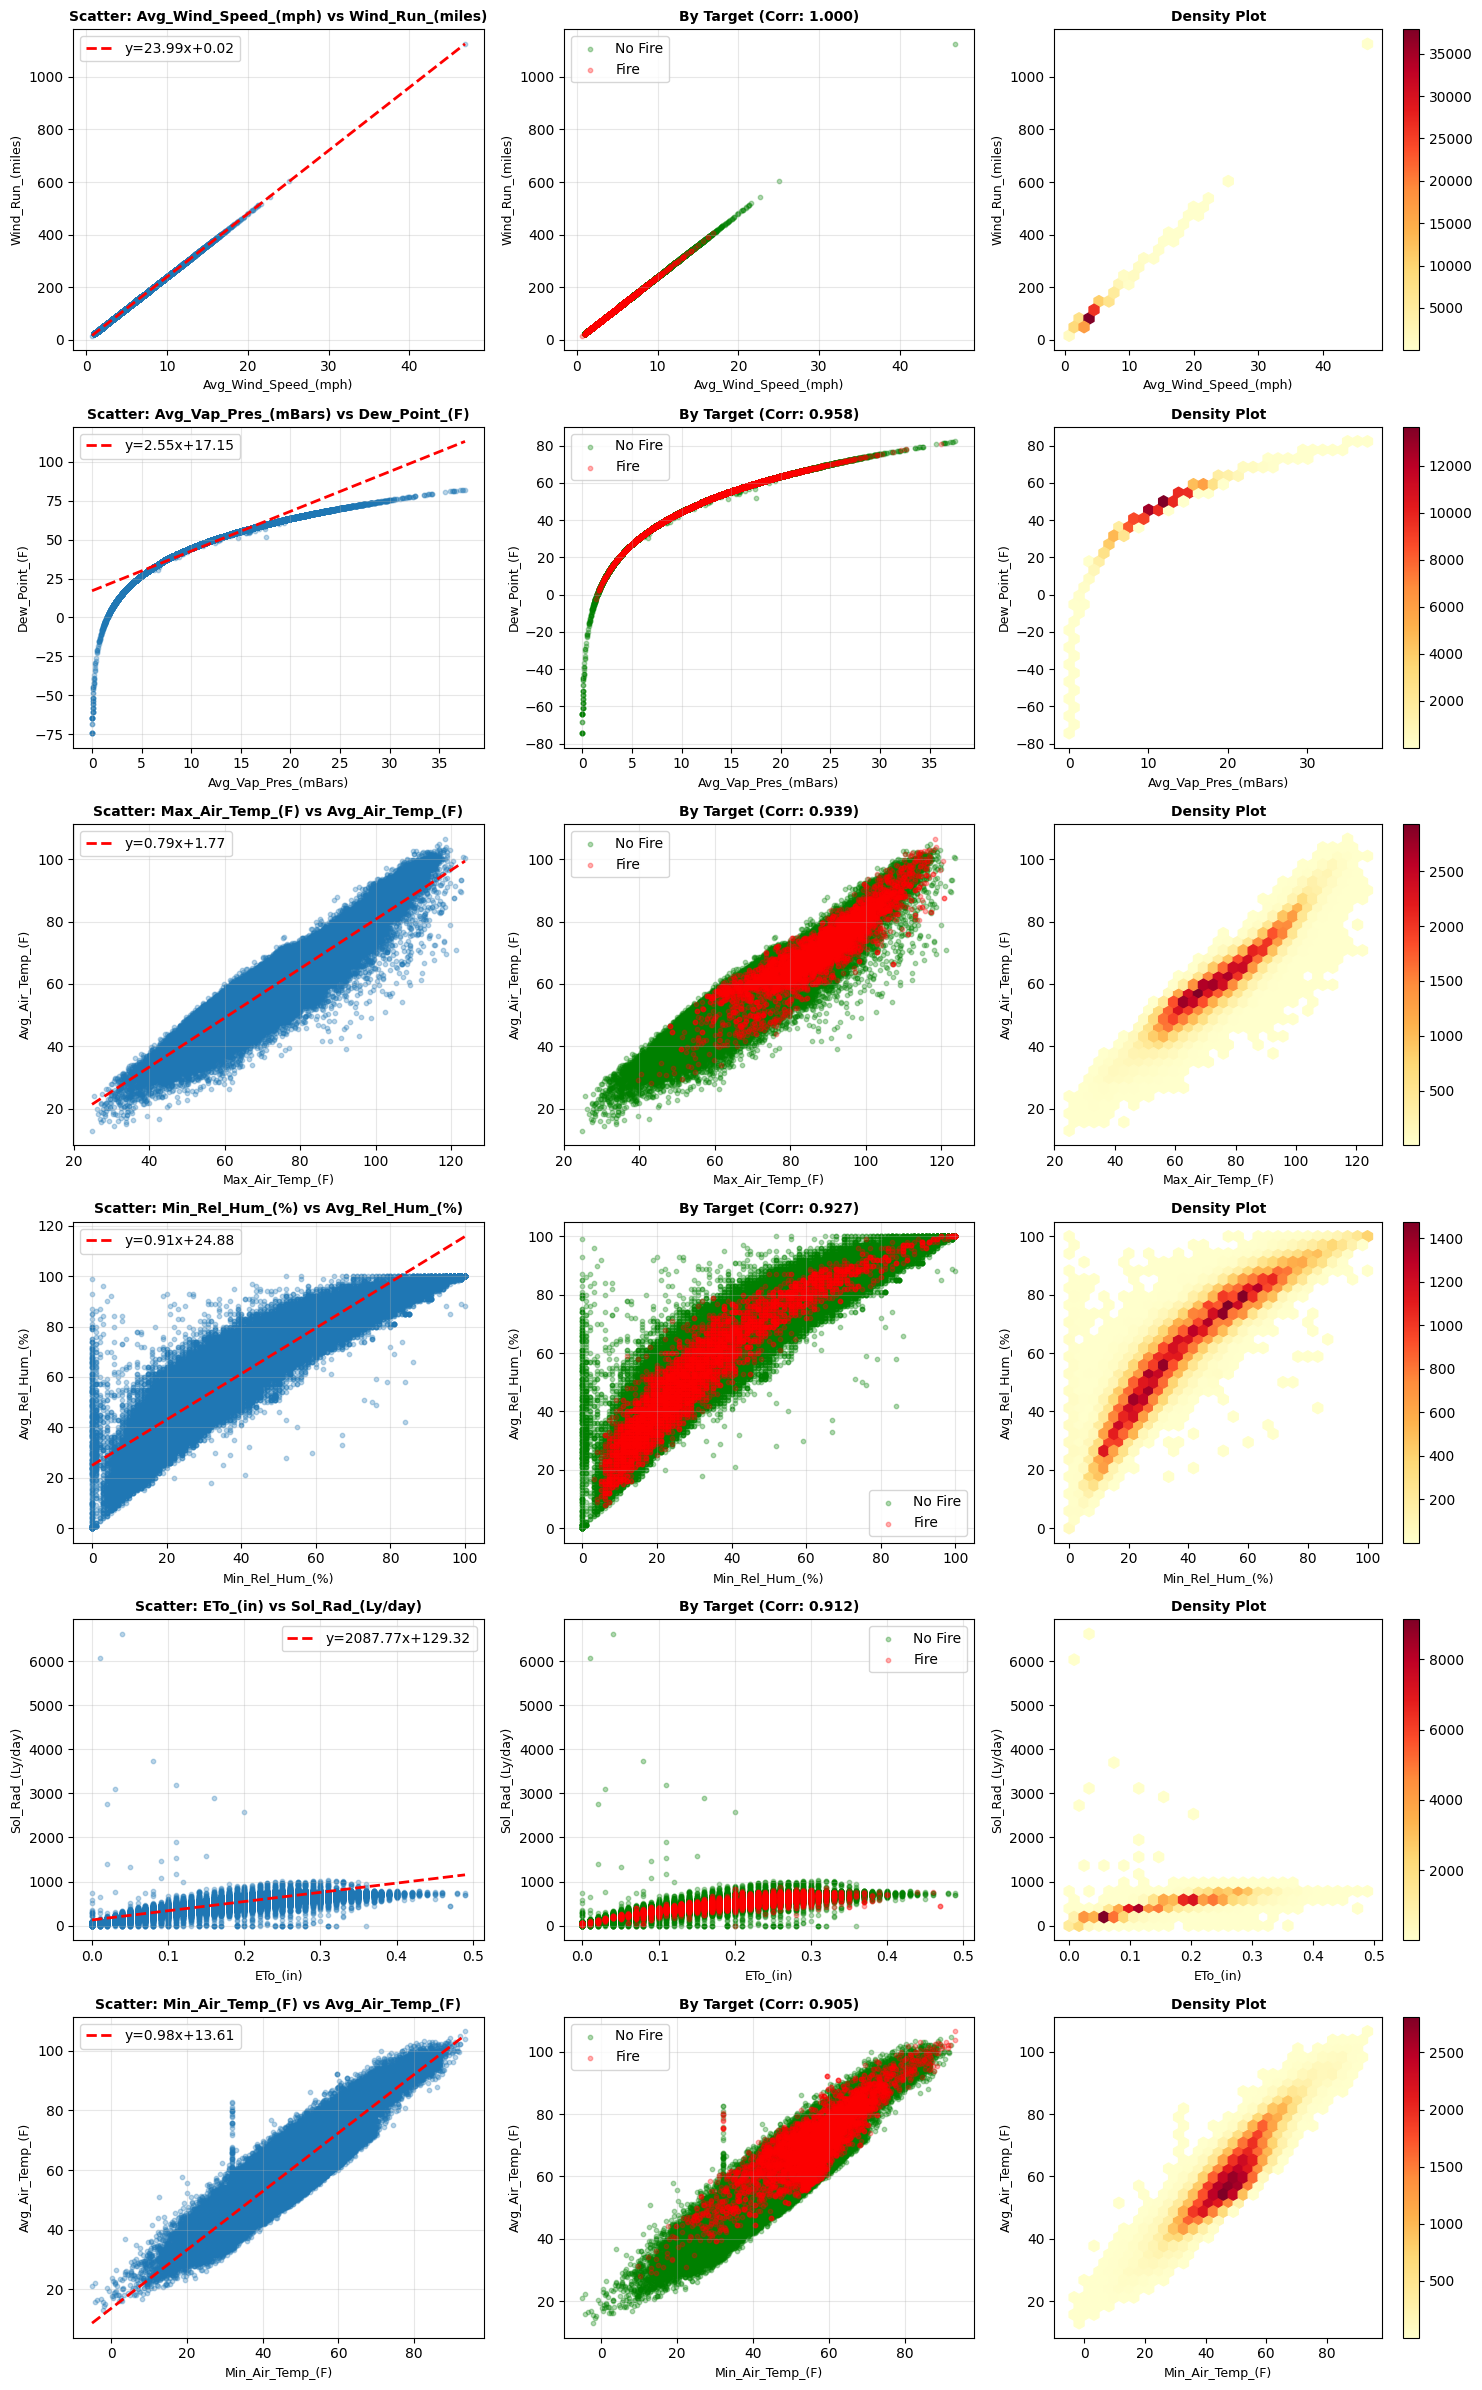

In [13]:
# Create detailed pairwise plots for top highly correlated pairs
num_pairs = len(high_corr_pairs)
if num_pairs > 0:
    top_n = min(6, num_pairs)  # Show top 6 pairs
    top_pairs = high_corr_df.head(top_n)
    
    fig, axes = plt.subplots(top_n, 3, figsize=(15, 4*top_n))
    if top_n == 1:
        axes = axes.reshape(1, -1)
    
    for idx, (_, pair) in enumerate(top_pairs.iterrows()):
        feat1 = pair['feature1']
        feat2 = pair['feature2']
        corr_val = pair['correlation']
        
        # Scatter plot with regression line
        valid_data = df[[feat1, feat2]].dropna()
        axes[idx, 0].scatter(valid_data[feat1], valid_data[feat2], alpha=0.3, s=10)
        z = np.polyfit(valid_data[feat1], valid_data[feat2], 1)
        p = np.poly1d(z)
        x_line = np.linspace(valid_data[feat1].min(), valid_data[feat1].max(), 100)
        axes[idx, 0].plot(x_line, p(x_line), "r--", linewidth=2, label=f'y={z[0]:.2f}x+{z[1]:.2f}')
        axes[idx, 0].set_xlabel(feat1, fontsize=9)
        axes[idx, 0].set_ylabel(feat2, fontsize=9)
        axes[idx, 0].set_title(f'Scatter: {feat1} vs {feat2}', fontsize=10, fontweight='bold')
        axes[idx, 0].legend()
        axes[idx, 0].grid(alpha=0.3)
        
        # Joint distribution by target
        no_fire = df[df['Target'] == 0]
        fire = df[df['Target'] == 1]
        axes[idx, 1].scatter(no_fire[feat1], no_fire[feat2], alpha=0.3, s=10, label='No Fire', c='green')
        axes[idx, 1].scatter(fire[feat1], fire[feat2], alpha=0.3, s=10, label='Fire', c='red')
        axes[idx, 1].set_xlabel(feat1, fontsize=9)
        axes[idx, 1].set_ylabel(feat2, fontsize=9)
        axes[idx, 1].set_title(f'By Target (Corr: {corr_val:.3f})', fontsize=10, fontweight='bold')
        axes[idx, 1].legend()
        axes[idx, 1].grid(alpha=0.3)
        
        # Hexbin plot for density
        hexbin = axes[idx, 2].hexbin(valid_data[feat1], valid_data[feat2], gridsize=30, cmap='YlOrRd', mincnt=1)
        axes[idx, 2].set_xlabel(feat1, fontsize=9)
        axes[idx, 2].set_ylabel(feat2, fontsize=9)
        axes[idx, 2].set_title(f'Density Plot', fontsize=10, fontweight='bold')
        plt.colorbar(hexbin, ax=axes[idx, 2])
    
    plt.tight_layout()
    plt.show()

### 3. Data cleaning:

In [14]:
df.dropna(inplace=True)
df.isnull().sum()

Stn_Id                  0
Stn_Name                0
CIMIS_Region            0
Date                    0
ETo_(in)                0
Precip_(in)             0
Sol_Rad_(Ly/day)        0
Avg_Vap_Pres_(mBars)    0
Max_Air_Temp_(F)        0
Min_Air_Temp_(F)        0
Avg_Air_Temp_(F)        0
Max_Rel_Hum_(%)         0
Min_Rel_Hum_(%)         0
Avg_Rel_Hum_(%)         0
Dew_Point_(F)           0
Avg_Wind_Speed_(mph)    0
Wind_Run_(miles)        0
Avg_Soil_Temp_(F)       0
Target                  0
Date_parsed             0
Year                    0
Month                   0
dtype: int64

In [15]:
# Removing unnecessary features
df.drop(columns="Stn_Name", inplace=True)

# Parsing date to date object
df['Date_parsed'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

### 4. Feature Engineering

In [16]:
# Sort by region, station and date to ensure proper time series calculations
df = df.sort_values(['CIMIS_Region', 'Stn_Id', 'Date_parsed']).reset_index(drop=True)

print("Creating rolling average features based on Date...")
print(f"Original dataframe shape: {df.shape}")

# Group by region and station for proper rolling calculations
grouped = df.groupby(['CIMIS_Region', 'Stn_Id'])

# ETo_(in) - previous day, 3 days, 5 days, 1 week, 2 weeks, 3 weeks
for days in [1, 3, 5, 7, 14, 21]:
    col_name = f'ETo_(in)_avg_{days}d'
    df[col_name] = grouped['ETo_(in)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Precip_(in) - previous day, 3 days, 5 days, 1 week, 2 weeks, 3 weeks
for days in [1, 3, 5, 7, 14, 21]:
    col_name = f'Precip_(in)_avg_{days}d'
    df[col_name] = grouped['Precip_(in)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Sol_Rad_(Ly/day) - previous day, 3 days, 5 days
for days in [1, 3, 5]:
    col_name = f'Sol_Rad_(Ly/day)_avg_{days}d'
    df[col_name] = grouped['Sol_Rad_(Ly/day)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Avg_Vap_Pres_(mBars) - previous day, 3 days, 5 days
for days in [1, 3, 5]:
    col_name = f'Avg_Vap_Pres_(mBars)_avg_{days}d'
    df[col_name] = grouped['Avg_Vap_Pres_(mBars)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Max_Air_Temp_(F) - 3 days, 5 days
for days in [3, 5]:
    col_name = f'Max_Air_Temp_(F)_avg_{days}d'
    df[col_name] = grouped['Max_Air_Temp_(F)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Min_Air_Temp_(F) - 3 days, 5 days
for days in [3, 5]:
    col_name = f'Min_Air_Temp_(F)_avg_{days}d'
    df[col_name] = grouped['Min_Air_Temp_(F)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Avg_Air_Temp_(F) - 3 days, 5 days
for days in [3, 5]:
    col_name = f'Avg_Air_Temp_(F)_avg_{days}d'
    df[col_name] = grouped['Avg_Air_Temp_(F)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Max_Rel_Hum_(%) - 3 days, 5 days, 1 week, 2 weeks, 3 weeks
for days in [3, 5, 7, 14, 21]:
    col_name = f'Max_Rel_Hum_(%)_avg_{days}d'
    df[col_name] = grouped['Max_Rel_Hum_(%)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Min_Rel_Hum_(%) - 3 days, 5 days, 1 week, 2 weeks, 3 weeks
for days in [3, 5, 7, 14, 21]:
    col_name = f'Min_Rel_Hum_(%)_avg_{days}d'
    df[col_name] = grouped['Min_Rel_Hum_(%)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Avg_Rel_Hum_(%) - 3 days, 5 days, 1 week, 2 weeks, 3 weeks
for days in [3, 5, 7, 14, 21]:
    col_name = f'Avg_Rel_Hum_(%)_avg_{days}d'
    df[col_name] = grouped['Avg_Rel_Hum_(%)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

# Avg_Soil_Temp_(F) - 3 days, 5 days
for days in [3, 5]:
    col_name = f'Avg_Soil_Temp_(F)_avg_{days}d'
    df[col_name] = grouped['Avg_Soil_Temp_(F)'].transform(lambda x: x.shift(1).rolling(window=days).mean())
    print(f"Created: {col_name}")

print(f"\nFinal dataframe shape: {df.shape}")
print(f"Total new features created: {df.shape[1] - 19}")  # 19 was the original number of columns

Creating rolling average features based on Date...
Original dataframe shape: (128009, 21)
Created: ETo_(in)_avg_1d
Created: ETo_(in)_avg_3d
Created: ETo_(in)_avg_5d
Created: ETo_(in)_avg_7d
Created: ETo_(in)_avg_14d
Created: ETo_(in)_avg_21d
Created: Precip_(in)_avg_1d
Created: Precip_(in)_avg_3d
Created: Precip_(in)_avg_5d
Created: Precip_(in)_avg_7d
Created: Precip_(in)_avg_14d
Created: Precip_(in)_avg_21d
Created: Sol_Rad_(Ly/day)_avg_1d
Created: Sol_Rad_(Ly/day)_avg_3d
Created: Sol_Rad_(Ly/day)_avg_5d
Created: Avg_Vap_Pres_(mBars)_avg_1d
Created: Avg_Vap_Pres_(mBars)_avg_3d
Created: Avg_Vap_Pres_(mBars)_avg_5d
Created: Max_Air_Temp_(F)_avg_3d
Created: Max_Air_Temp_(F)_avg_5d
Created: Min_Air_Temp_(F)_avg_3d
Created: Min_Air_Temp_(F)_avg_5d
Created: Avg_Air_Temp_(F)_avg_3d
Created: Avg_Air_Temp_(F)_avg_5d
Created: Max_Rel_Hum_(%)_avg_3d
Created: Max_Rel_Hum_(%)_avg_5d
Created: Max_Rel_Hum_(%)_avg_7d
Created: Max_Rel_Hum_(%)_avg_14d
Created: Sol_Rad_(Ly/day)_avg_1d
Created: Sol_Rad_(

In [17]:
# Show sample data with some new features
sample_cols = ['Date', 'CIMIS_Region', 'Stn_Id', 'ETo_(in)', 'ETo_(in)_avg_1d', 'ETo_(in)_avg_3d', 'ETo_(in)_avg_7d']
print(f"\nSample data with new features:")
df[sample_cols].head(10)


Sample data with new features:


,Date,CIMIS_Region,Stn_Id,ETo_(in),ETo_(in)_avg_1d,ETo_(in)_avg_3d,ETo_(in)_avg_7d
0,1/1/2018,Bishop,35,0.07,NaN,NaN,NaN
1,1/2/2018,Bishop,35,0.04,0.07,NaN,NaN
2,1/3/2018,Bishop,35,0.07,0.04,NaN,NaN
3,1/4/2018,Bishop,35,0.06,0.07,0.060000,NaN
4,1/5/2018,Bishop,35,0.06,0.06,0.056667,NaN
5,1/6/2018,Bishop,35,0.07,0.06,0.063333,NaN
6,1/7/2018,Bishop,35,0.07,0.07,0.063333,NaN
7,1/8/2018,Bishop,35,0.02,0.07,0.066667,0.062857
8,1/10/2018,Bishop,35,0.05,0.02,0.053333,0.055714
9,1/11/2018,Bishop,35,0.05,0.05,0.046667,0.057143


Missing values in new rolling average features:
ETo_(in)_avg_1d                 143
ETo_(in)_avg_3d                 429
ETo_(in)_avg_5d                 715
ETo_(in)_avg_7d                1001
ETo_(in)_avg_14d               2002
ETo_(in)_avg_21d               3003
Precip_(in)_avg_1d              143
Precip_(in)_avg_3d              429
Precip_(in)_avg_5d              715
Precip_(in)_avg_7d             1001
Precip_(in)_avg_14d            2002
Precip_(in)_avg_21d            3003
Sol_Rad_(Ly/day)_avg_1d         143
Sol_Rad_(Ly/day)_avg_3d         429
Sol_Rad_(Ly/day)_avg_5d         715
Avg_Vap_Pres_(mBars)_avg_1d     143
Avg_Vap_Pres_(mBars)_avg_3d     429
Avg_Vap_Pres_(mBars)_avg_5d     715
Max_Air_Temp_(F)_avg_3d         429
Max_Air_Temp_(F)_avg_5d         715
Min_Air_Temp_(F)_avg_3d         429
Min_Air_Temp_(F)_avg_5d         715
Avg_Air_Temp_(F)_avg_3d         429
Avg_Air_Temp_(F)_avg_5d         715
Max_Rel_Hum_(%)_avg_3d          429
Max_Rel_Hum_(%)_avg_5d          715
Max_Rel_Hum_(%)_

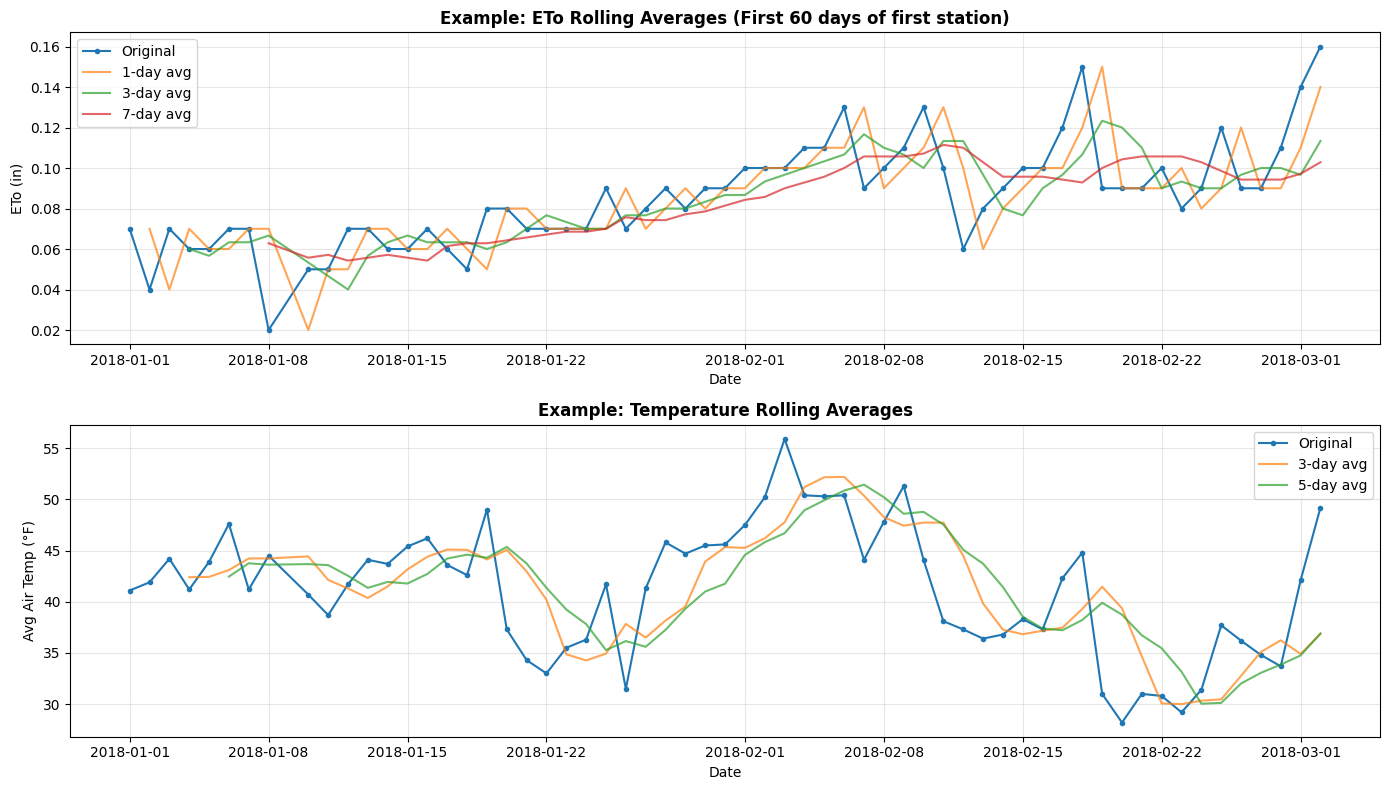

In [18]:
# Display sample of new features
new_feature_cols = [col for col in df.columns if '_avg_' in col]

# Check for missing values in new features
new_feature_missing = df[new_feature_cols].isnull().sum()
print("Missing values in new rolling average features:")
print(new_feature_missing[new_feature_missing > 0])

# Visualize one example: ETo rolling averages
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot for a single station
station_sample = df[df['Stn_Id'] == df['Stn_Id'].iloc[0]].head(60)

axes[0].plot(station_sample['Date_parsed'], station_sample['ETo_(in)'], label='Original', marker='o', markersize=3)
axes[0].plot(station_sample['Date_parsed'], station_sample['ETo_(in)_avg_1d'], label='1-day avg', alpha=0.7)
axes[0].plot(station_sample['Date_parsed'], station_sample['ETo_(in)_avg_3d'], label='3-day avg', alpha=0.7)
axes[0].plot(station_sample['Date_parsed'], station_sample['ETo_(in)_avg_7d'], label='7-day avg', alpha=0.7)
axes[0].set_xlabel('Date')
axes[0].set_ylabel('ETo (in)')
axes[0].set_title('Example: ETo Rolling Averages (First 60 days of first station)', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot for temperature averages
axes[1].plot(station_sample['Date_parsed'], station_sample['Avg_Air_Temp_(F)'], label='Original', marker='o', markersize=3)
axes[1].plot(station_sample['Date_parsed'], station_sample['Avg_Air_Temp_(F)_avg_3d'], label='3-day avg', alpha=0.7)
axes[1].plot(station_sample['Date_parsed'], station_sample['Avg_Air_Temp_(F)_avg_5d'], label='5-day avg', alpha=0.7)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Avg Air Temp (°F)')
axes[1].set_title('Example: Temperature Rolling Averages', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Checking if parameters were correcly added

In [19]:
# There is an error when creatin parameters FOR SURE

df[["CIMIS_Region", "Stn_Id", "Date", "ETo_(in)_avg_1d", "ETo_(in)_avg_21d"]].sort_values(by="ETo_(in)_avg_1d", na_position='first')[:10]

,CIMIS_Region,Stn_Id,Date,ETo_(in)_avg_1d,ETo_(in)_avg_21d
0,Bishop,35,1/1/2018,NaN,NaN
1004,Bishop,257,10/10/2018,NaN,NaN
1713,Central Coast Valleys,52,1/1/2018,NaN,NaN
2613,Central Coast Valleys,64,1/1/2018,NaN,NaN
3478,Central Coast Valleys,88,1/1/2018,NaN,NaN
4408,Central Coast Valleys,107,1/1/2018,NaN,NaN
5183,Central Coast Valleys,152,1/1/2018,NaN,NaN
6158,Central Coast Valleys,160,1/1/2018,NaN,NaN
7123,Central Coast Valleys,163,1/1/2018,NaN,NaN
8026,Central Coast Valleys,165,1/23/2018,NaN,NaN


In [20]:
df[["CIMIS_Region", "Stn_Id", "Date", "ETo_(in)_avg_1d", "ETo_(in)_avg_21d"]].loc[df["Stn_Id"] == 245][20:23]

,CIMIS_Region,Stn_Id,Date,ETo_(in)_avg_1d,ETo_(in)_avg_21d
127054,South Coast Valleys,245,1/21/2018,0.08,NaN
127055,South Coast Valleys,245,1/22/2018,0.08,0.071905
127056,South Coast Valleys,245,1/23/2018,0.09,0.073333


In [21]:
# Getting first and last date after removing missing values
print("First date before removing missing values:", df["Date_parsed"].head(1).to_string(index=False))
print("Last date before removing missing values:", df["Date_parsed"].tail(1).to_string(index=False))
print("\nMissing values total:", df.isna().sum().sum())

First date before removing missing values: 2018-01-01
Last date before removing missing values: 2020-09-15

Missing values total: 43186

Missing values total: 43186


In [22]:
# UNDERSTAND WHY I AM DROPPING TIME SERIES AND THE DATE IS NOT CHANING, I AM DOING SOMETHING WRONG
df.dropna(inplace=True)

In [23]:
# Getting first and last date after removing missing values
print("First date after removing missing values:", df["Date_parsed"].head(1).to_string(index=False))
print("Last date after removing missing values:", df["Date_parsed"].tail(1).to_string(index=False))
print("\nMissing values total:", df.isna().sum().sum())

First date after removing missing values: 2018-01-23
Last date after removing missing values: 2020-09-15

Missing values total: 0


In [24]:
# Converting "CIMIS_Region" to numbers using ordinal encoding
encoder = OrdinalEncoder()
encoded = encoder.fit_transform(df[["CIMIS_Region"]])
df["CIMIS_Region_encoded"] = encoded  

print("Ordinal encoding applied to CIMIS_Region:")
for i, region in enumerate(encoder.categories_[0]):
    print(f"  {region}: {i}")
print(f"\nNew column 'CIMIS_Region_encoded' created with shape: {df['CIMIS_Region_encoded'].shape}")

Ordinal encoding applied to CIMIS_Region:
  Bishop: 0
  Central Coast Valleys: 1
  Eastern Sierra Basin  Range: 2
  Imperial/Coachella Valley: 3
  Los Angeles Basin: 4
  Monterey Bay: 5
  North Coast Valleys: 6
  Northeast Plateau: 7
  Sacramento Valley: 8
  San Bernardino: 9
  San Francisco Bay: 10
  San Joaquin Valley: 11
  Sierra Foothill: 12
  South Coast Valleys: 13

New column 'CIMIS_Region_encoded' created with shape: (125006,)


### 5. Model training

In [25]:
# Separating data and dropping not useful columns
# Remove Target, date-related columns, and original CIMIS_Region (keep encoded version)
X = df.drop(columns=["Target", "Date", "Date_parsed", "Year", "Month", "CIMIS_Region"])
y = df["Target"]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns (first 10): {list(X.columns)[:10]}")
print(f"\nTarget distribution:\n{y.value_counts()}")

# Verify all columns are numeric
print(f"\nData types in X:")
print(X.dtypes.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Features shape: (125006, 57)
Target shape: (125006,)

Feature columns (first 10): ['Stn_Id', 'ETo_(in)', 'Precip_(in)', 'Sol_Rad_(Ly/day)', 'Avg_Vap_Pres_(mBars)', 'Max_Air_Temp_(F)', 'Min_Air_Temp_(F)', 'Avg_Air_Temp_(F)', 'Max_Rel_Hum_(%)', 'Min_Rel_Hum_(%)']

Target distribution:
Target
0    119678
1      5328
Name: count, dtype: int64

Data types in X:
float64    56
int64       1
Name: count, dtype: int64

Training set: 100004 samples
Test set: 25002 samples


### Neural Network Training Note

The Neural Network with 50 fully connected layers (100 neurons each) is now integrated with the other models below. It will be trained together with Random Forest, AdaBoost, and Gradient Boosting for comprehensive comparison.

**Neural Network Architecture:**
- 50 hidden layers
- 100 neurons per layer
- ReLU activation
- Adam optimizer
- Early stopping enabled

In [26]:
# Initialize results dictionary and scoring metrics
results = {}

# Define scoring metrics for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

print("Ready to train models with 3-fold cross-validation")
print("="*80)

Ready to train models with 3-fold cross-validation


In [1]:
# Model 1: Random Forest
print("\n" + "="*80)
print("RANDOM FOREST")
print("="*80)

# Initialize model with hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=200,      # Number of trees
    random_state=42,
    n_jobs=-1,             # Use all CPU cores
    max_depth=None,        # Unlimited depth
    min_samples_split=2,
    min_samples_leaf=1
)

# Perform cross-validation
print("\nPerforming 3-fold cross-validation...")
cv_results = cross_validate(rf_model, X_train, y_train, cv=3, scoring=scoring, n_jobs=-1)

# Store CV results
results['Random Forest'] = {
    'cv_accuracy': cv_results['test_accuracy'],
    'cv_precision': cv_results['test_precision'],
    'cv_recall': cv_results['test_recall'],
    'cv_f1': cv_results['test_f1']
}

# Print CV results
print(f"\nCross-Validation Results:")
print(f"  Accuracy:  {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")
print(f"  Precision: {cv_results['test_precision'].mean():.4f} (+/- {cv_results['test_precision'].std():.4f})")
print(f"  Recall:    {cv_results['test_recall'].mean():.4f} (+/- {cv_results['test_recall'].std():.4f})")
print(f"  F1-Score:  {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std():.4f})")

# Train on full training set
print(f"\nTraining on full training set...")
rf_model.fit(X_train, y_train)

# Predict and evaluate on test set
y_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

# Store test results
results['Random Forest']['test_accuracy'] = test_accuracy
results['Random Forest']['test_precision'] = test_precision
results['Random Forest']['test_recall'] = test_recall
results['Random Forest']['test_f1'] = test_f1
results['Random Forest']['model'] = rf_model

# Print test results
print(f"\nTest Set Results:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")


RANDOM FOREST


NameError: name 'RandomForestClassifier' is not defined

In [28]:
# Model 2: AdaBoost
print("\n" + "="*80)
print("ADABOOST")
print("="*80)

# Initialize model with hyperparameters
ada_model = AdaBoostClassifier(
    n_estimators=100,      # Number of boosting stages
    random_state=42,
    learning_rate=1.0,     # Weight applied to each classifier
    algorithm='SAMME'      # Algorithm type
)

# Perform cross-validation
print("\nPerforming 3-fold cross-validation...")
cv_results = cross_validate(ada_model, X_train, y_train, cv=3, scoring=scoring, n_jobs=-1)

# Store CV results
results['AdaBoost'] = {
    'cv_accuracy': cv_results['test_accuracy'],
    'cv_precision': cv_results['test_precision'],
    'cv_recall': cv_results['test_recall'],
    'cv_f1': cv_results['test_f1']
}

# Print CV results
print(f"\nCross-Validation Results:")
print(f"  Accuracy:  {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")
print(f"  Precision: {cv_results['test_precision'].mean():.4f} (+/- {cv_results['test_precision'].std():.4f})")
print(f"  Recall:    {cv_results['test_recall'].mean():.4f} (+/- {cv_results['test_recall'].std():.4f})")
print(f"  F1-Score:  {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std():.4f})")

# Train on full training set
print(f"\nTraining on full training set...")
ada_model.fit(X_train, y_train)

# Predict and evaluate on test set
y_pred = ada_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

# Store test results
results['AdaBoost']['test_accuracy'] = test_accuracy
results['AdaBoost']['test_precision'] = test_precision
results['AdaBoost']['test_recall'] = test_recall
results['AdaBoost']['test_f1'] = test_f1
results['AdaBoost']['model'] = ada_model

# Print test results
print(f"\nTest Set Results:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")


ADABOOST

Performing 3-fold cross-validation...


/Users/pedrocosta/Documents/GitHub/Machine-Learning-Final-Project/.venv/lib/python3.14/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/pedrocosta/Documents/GitHub/Machine-Learning-Final-Project/.venv/lib/python3.14/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/pedrocosta/Documents/GitHub/Machine-Learning-Final-Project/.venv/lib/python3.14/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/pedrocosta/Documents/GitHub/Machine-Learning-Final-Project/.venv/lib/python3.14/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 


Cross-Validation Results:
  Accuracy:  0.9571 (+/- 0.0003)
  Precision: 0.4456 (+/- 0.0501)
  Recall:    0.0246 (+/- 0.0030)
  F1-Score:  0.0466 (+/- 0.0054)

Training on full training set...


/Users/pedrocosta/Documents/GitHub/Machine-Learning-Final-Project/.venv/lib/python3.14/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



Test Set Results:
  Accuracy:  0.9570
  Precision: 0.4574
  Recall:    0.0403
  F1-Score:  0.0741


In [29]:
# Model 3: Gradient Boosting
print("\n" + "="*80)
print("GRADIENT BOOSTING")
print("="*80)

# Initialize model with hyperparameters
gb_model = GradientBoostingClassifier(
    n_estimators=100,      # Number of boosting stages
    random_state=42,
    learning_rate=0.1,     # Shrinks contribution of each tree
    max_depth=3,           # Maximum depth of individual trees
    min_samples_split=2,
    min_samples_leaf=1,
    subsample=1.0          # Fraction of samples for fitting trees
)

# Perform cross-validation
print("\nPerforming 3-fold cross-validation...")
cv_results = cross_validate(gb_model, X_train, y_train, cv=3, scoring=scoring, n_jobs=-1)

# Store CV results
results['Gradient Boosting'] = {
    'cv_accuracy': cv_results['test_accuracy'],
    'cv_precision': cv_results['test_precision'],
    'cv_recall': cv_results['test_recall'],
    'cv_f1': cv_results['test_f1']
}

# Print CV results
print(f"\nCross-Validation Results:")
print(f"  Accuracy:  {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")
print(f"  Precision: {cv_results['test_precision'].mean():.4f} (+/- {cv_results['test_precision'].std():.4f})")
print(f"  Recall:    {cv_results['test_recall'].mean():.4f} (+/- {cv_results['test_recall'].std():.4f})")
print(f"  F1-Score:  {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std():.4f})")

# Train on full training set
print(f"\nTraining on full training set...")
gb_model.fit(X_train, y_train)

# Predict and evaluate on test set
y_pred = gb_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

# Store test results
results['Gradient Boosting']['test_accuracy'] = test_accuracy
results['Gradient Boosting']['test_precision'] = test_precision
results['Gradient Boosting']['test_recall'] = test_recall
results['Gradient Boosting']['test_f1'] = test_f1
results['Gradient Boosting']['model'] = gb_model

# Print test results
print(f"\nTest Set Results:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")


GRADIENT BOOSTING

Performing 3-fold cross-validation...

Cross-Validation Results:
  Accuracy:  0.9643 (+/- 0.0001)
  Precision: 0.7893 (+/- 0.0126)
  Recall:    0.2215 (+/- 0.0081)
  F1-Score:  0.3457 (+/- 0.0087)

Training on full training set...

Cross-Validation Results:
  Accuracy:  0.9643 (+/- 0.0001)
  Precision: 0.7893 (+/- 0.0126)
  Recall:    0.2215 (+/- 0.0081)
  F1-Score:  0.3457 (+/- 0.0087)

Training on full training set...

Test Set Results:
  Accuracy:  0.9646
  Precision: 0.7855
  Recall:    0.2336
  F1-Score:  0.3601

Test Set Results:
  Accuracy:  0.9646
  Precision: 0.7855
  Recall:    0.2336
  F1-Score:  0.3601


In [30]:
# Model 4: Neural Network (50 layers)
print("\n" + "="*80)
print("NEURAL NETWORK (50 LAYERS)")
print("="*80)

# Initialize model with hyperparameters
nn_model = MLPClassifier(
    hidden_layer_sizes=tuple([100] * 90),  # 90 hidden layers with 100 neurons each
    activation='relu',                      # Activation function
    solver='adam',                          # Optimizer
    max_iter=200,                           # Maximum iterations
    random_state=42,
    verbose=True,                           # Show training progress
    early_stopping=True,                    # Stop when validation score stops improving
    validation_fraction=0.1,                # Fraction of training data for validation
    learning_rate_init=0.001,               # Initial learning rate
    batch_size='auto',                      # Batch size for training
    alpha=0.0001                            # L2 regularization parameter
)

# Perform cross-validation
print("\nPerforming 3-fold cross-validation...")
cv_results = cross_validate(nn_model, X_train, y_train, cv=3, scoring=scoring, n_jobs=-1)

# Store CV results
results['Neural Network (50 layers)'] = {
    'cv_accuracy': cv_results['test_accuracy'],
    'cv_precision': cv_results['test_precision'],
    'cv_recall': cv_results['test_recall'],
    'cv_f1': cv_results['test_f1']
}

# Print CV results
print(f"\nCross-Validation Results:")
print(f"  Accuracy:  {cv_results['test_accuracy'].mean():.4f} (+/- {cv_results['test_accuracy'].std():.4f})")
print(f"  Precision: {cv_results['test_precision'].mean():.4f} (+/- {cv_results['test_precision'].std():.4f})")
print(f"  Recall:    {cv_results['test_recall'].mean():.4f} (+/- {cv_results['test_recall'].std():.4f})")
print(f"  F1-Score:  {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std():.4f})")

# Train on full training set
print(f"\nTraining on full training set...")
nn_model.fit(X_train, y_train)

# Predict and evaluate on test set
y_pred = nn_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

# Store test results
results['Neural Network (50 layers)']['test_accuracy'] = test_accuracy
results['Neural Network (50 layers)']['test_precision'] = test_precision
results['Neural Network (50 layers)']['test_recall'] = test_recall
results['Neural Network (50 layers)']['test_f1'] = test_f1
results['Neural Network (50 layers)']['model'] = nn_model

# Print test results
print(f"\nTest Set Results:")
print(f"  Accuracy:  {test_accuracy:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")


NEURAL NETWORK (50 LAYERS)

Performing 3-fold cross-validation...
Iteration 1, loss = 0.18598102
Validation score: 0.957402
Iteration 1, loss = 0.18598102
Validation score: 0.957402
Iteration 1, loss = 0.18621973
Iteration 1, loss = 0.18621973
Iteration 1, loss = 0.18621973
Iteration 1, loss = 0.18621973
Validation score: 0.957402
Validation score: 0.957402
Validation score: 0.957402
Validation score: 0.957402
Iteration 2, loss = 0.17747829
Validation score: 0.957402
Iteration 2, loss = 0.17747829
Validation score: 0.957402
Iteration 2, loss = 0.17747829
Iteration 2, loss = 0.17747829
Validation score: 0.957402
Validation score: 0.957402
Iteration 2, loss = 0.17793202
Iteration 2, loss = 0.17793202
Validation score: 0.957402
Validation score: 0.957402
Iteration 3, loss = 0.17694520
Iteration 3, loss = 0.17694520
Validation score: 0.957402
Validation score: 0.957402
Iteration 3, loss = 0.17694520
Iteration 3, loss = 0.17694520
Validation score: 0.957402
Validation score: 0.957402
Itera

/Users/pedrocosta/Documents/GitHub/Machine-Learning-Final-Project/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Iteration 12, loss = 0.17668749
Validation score: 0.957402
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/Users/pedrocosta/Documents/GitHub/Machine-Learning-Final-Project/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


Iteration 12, loss = 0.17674416
Validation score: 0.957402
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/Users/pedrocosta/Documents/GitHub/Machine-Learning-Final-Project/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Cross-Validation Results:
  Accuracy:  0.9574 (+/- 0.0000)
  Precision: 0.0000 (+/- 0.0000)
  Recall:    0.0000 (+/- 0.0000)
  F1-Score:  0.0000 (+/- 0.0000)

Training on full training set...
Iteration 1, loss = 0.18267111
Validation score: 0.957404
Iteration 1, loss = 0.18267111
Validation score: 0.957404
Iteration 2, loss = 0.17736305
Iteration 2, loss = 0.17736305
Validation score: 0.957404
Validation score: 0.957404
Iteration 3, loss = 0.17723073
Iteration 3, loss = 0.17723073
Validation score: 0.957404
Validation score: 0.957404
Iteration 4, loss = 0.17722632
Iteration 4, loss = 0.17722632
Validation score: 0.957404
Validation score: 0.957404
Iteration 5, loss = 0.17683200
Iteration 5, loss = 0.17683200
Validation score: 0.957404
Validation score: 0.957404
Iteration 6, loss = 0.17677484
Validation score: 0.957404
Iteration 6, loss = 0.17677484
Validation score: 0.957404
Iteration 7, loss = 0.17675471
Iteration 7, loss = 0.17675471
Validation score: 0.957404
Validation score: 0.95

/Users/pedrocosta/Documents/GitHub/Machine-Learning-Final-Project/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [31]:
# Summary: All models trained
print("\n" + "="*80)
print("TRAINING COMPLETED FOR ALL 4 MODELS!")
print("="*80)
print(f"\nModels trained: {list(results.keys())}")
print("\nYou can now run the comparison and visualization cells below.")


TRAINING COMPLETED FOR ALL 4 MODELS!

Models trained: ['Random Forest', 'AdaBoost', 'Gradient Boosting', 'Neural Network (50 layers)']

You can now run the comparison and visualization cells below.


In [32]:
# Create comprehensive comparison DataFrame for all 4 models
comparison_data = []
model_names = list(results.keys())

for model_name in model_names:
    comparison_data.append({
        'Model': model_name,
        'CV Accuracy (mean)': results[model_name]['cv_accuracy'].mean(),
        'CV Precision (mean)': results[model_name]['cv_precision'].mean(),
        'CV Recall (mean)': results[model_name]['cv_recall'].mean(),
        'CV F1-Score (mean)': results[model_name]['cv_f1'].mean(),
        'Test Accuracy': results[model_name]['test_accuracy'],
        'Test Precision': results[model_name]['test_precision'],
        'Test Recall': results[model_name]['test_recall'],
        'Test F1-Score': results[model_name]['test_f1']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison Summary (All 4 Models):")
print("="*80)
comparison_df


Model Comparison Summary (All 4 Models):


,Model,CV Accuracy (mean),CV Precision (mean),CV Recall (mean),CV F1-Score (mean),Test Accuracy,Test Precision,Test Recall,Test F1-Score
0,Random Forest,0.974701,0.952729,0.427730,0.590257,0.978202,0.969369,0.504690,0.663788
1,AdaBoost,0.957092,0.445553,0.024637,0.046622,0.957043,0.457447,0.040338,0.074138
2,Gradient Boosting,0.964291,0.789287,0.221490,0.345750,0.964603,0.785489,0.233583,0.360087
3,Neural Network (50 layers),0.957382,0.000000,0.000000,0.000000,0.957363,0.000000,0.000000,0.000000


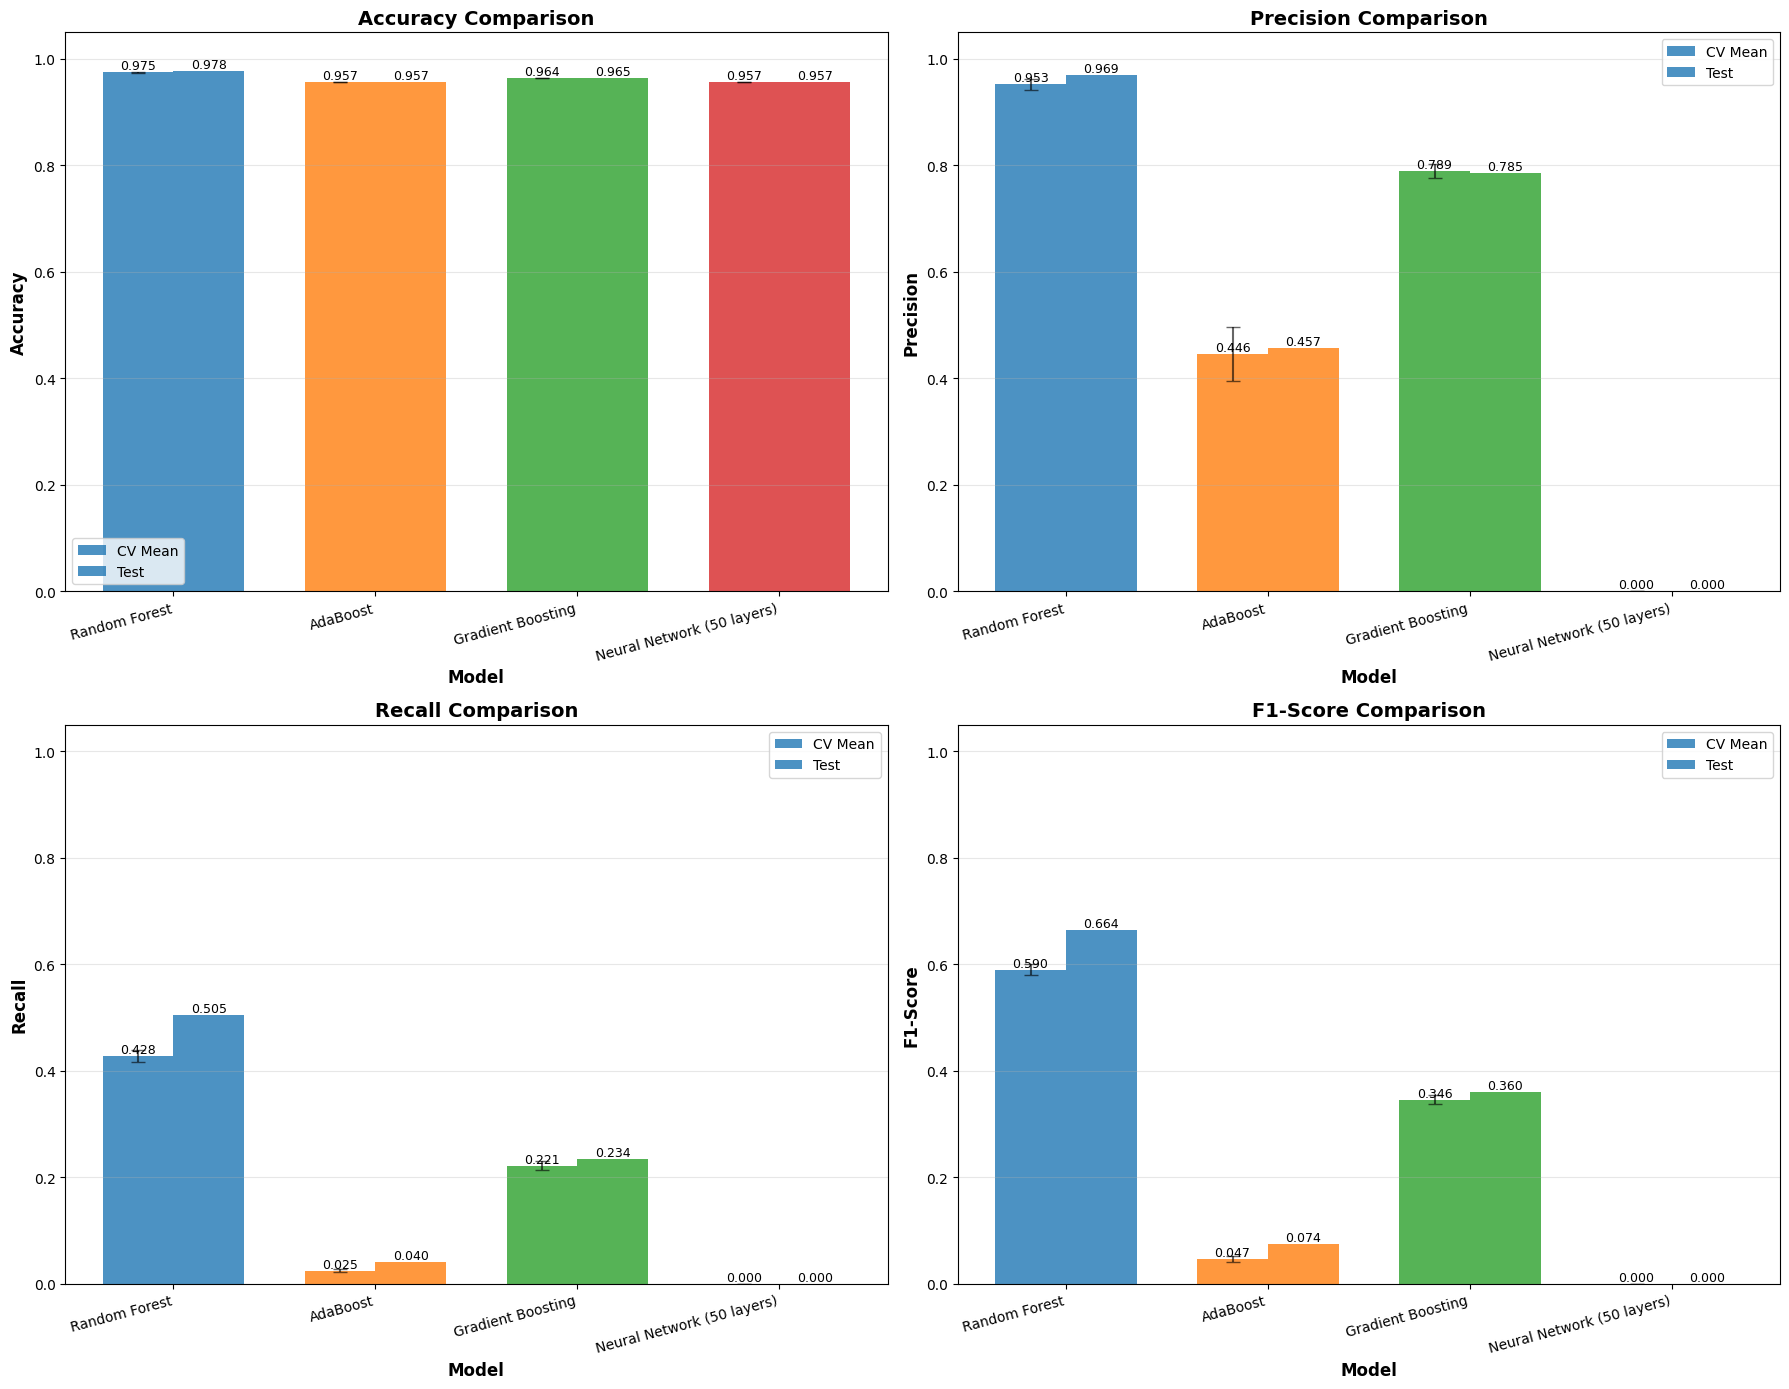

In [33]:
# Visualize model performance comparison (All 4 Models)
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_keys = ['accuracy', 'precision', 'recall', 'f1']  # Correct metric keys for results dict
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Added 4th color for neural network

model_names = list(results.keys())

for idx, (metric, metric_key) in enumerate(zip(metrics, metric_keys)):
    ax = axes[idx // 2, idx % 2]
    
    # Get CV and Test scores using correct metric keys
    cv_scores = [results[model][f'cv_{metric_key}'].mean() for model in model_names]
    test_scores = [results[model][f'test_{metric_key}'] for model in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, cv_scores, width, label='CV Mean', alpha=0.8, color=colors)
    bars2 = ax.bar(x + width/2, test_scores, width, label='Test', alpha=0.8, color=[c for c in colors])
    
    # Add error bars for CV scores
    cv_stds = [results[model][f'cv_{metric_key}'].std() for model in model_names]
    ax.errorbar(x - width/2, cv_scores, yerr=cv_stds, fmt='none', ecolor='black', capsize=5, alpha=0.6)
    
    ax.set_xlabel('Model', fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=15, ha='right')
    ax.legend()
    ax.grid(alpha=0.3, axis='y')
    ax.set_ylim([0, 1.05])
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

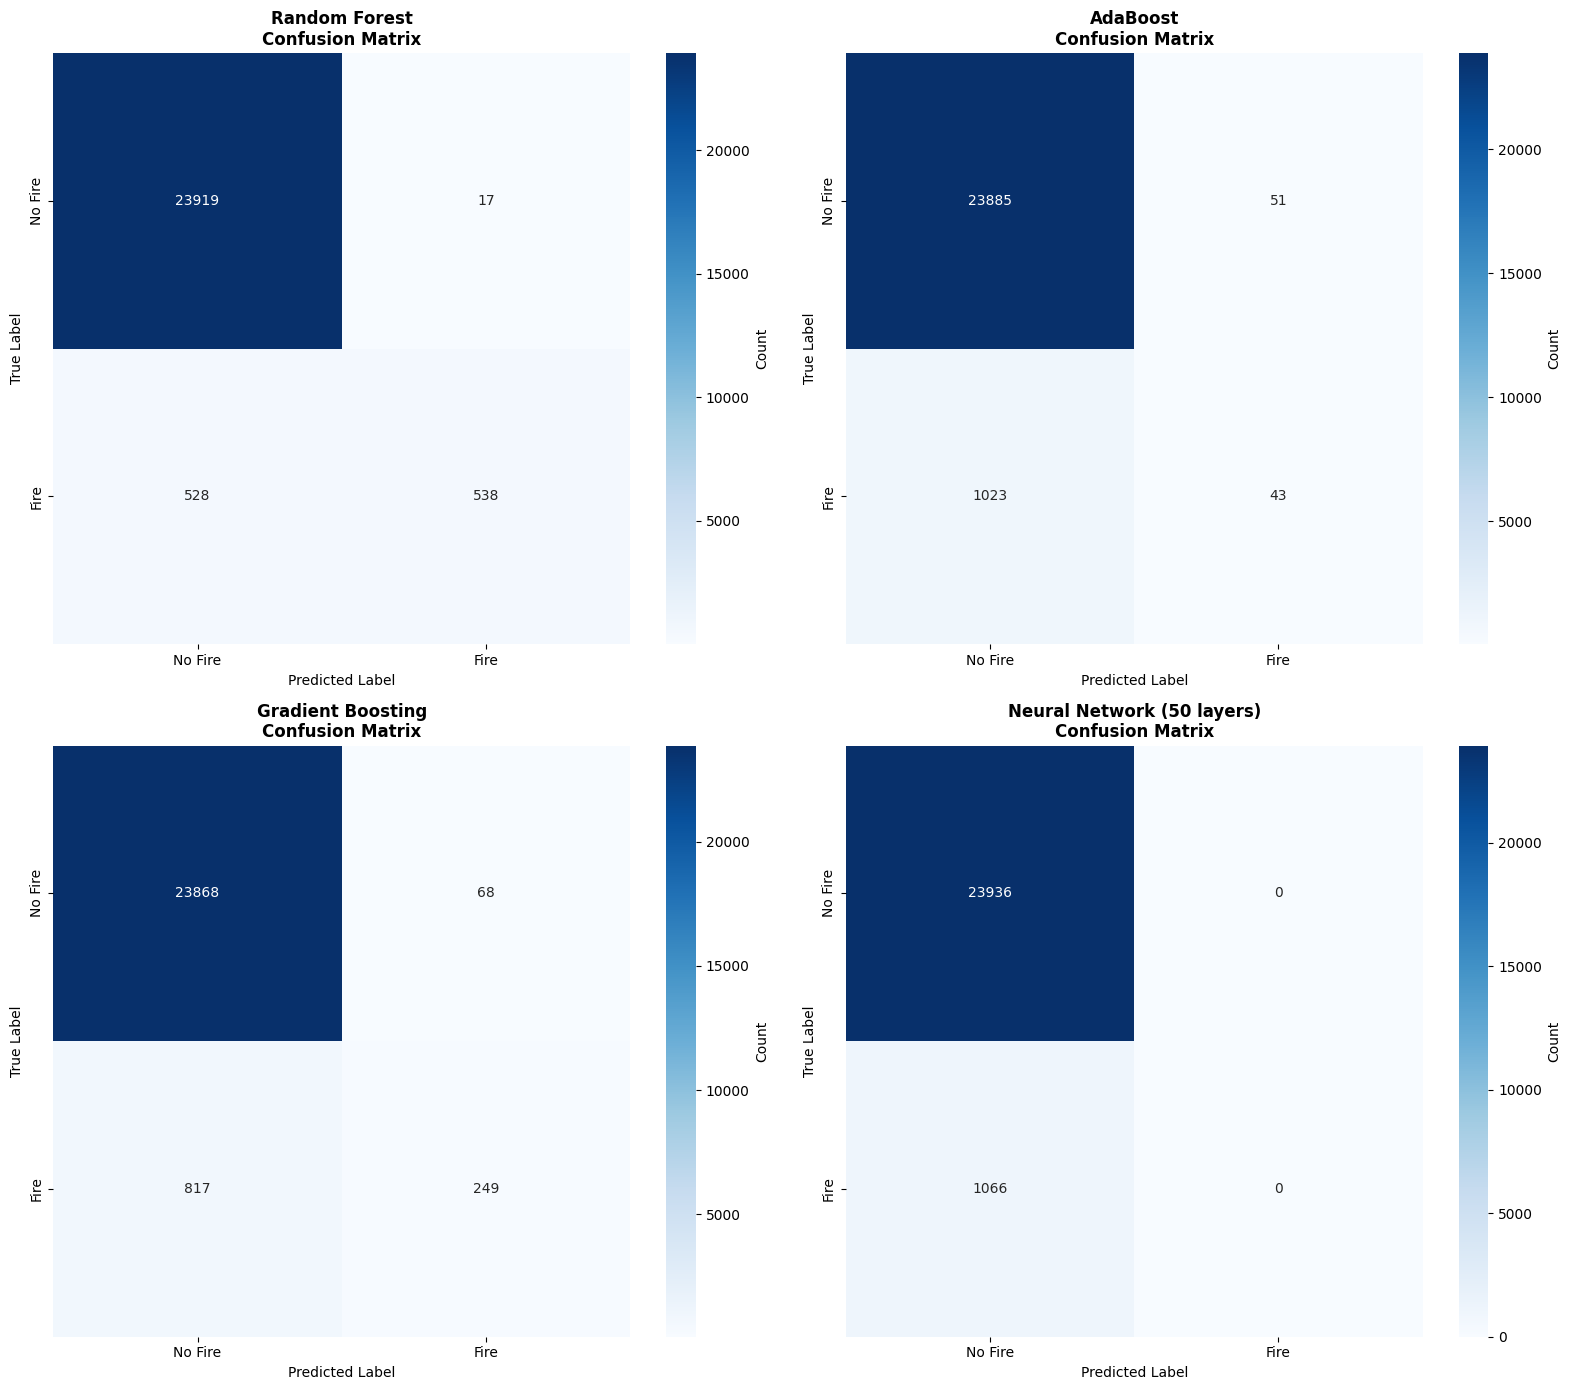

In [34]:
# Display confusion matrices for all 4 models
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

for idx, (model_name, model_data) in enumerate(results.items()):
    model = model_data['model']
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix in 2x2 grid
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar_kws={'label': 'Count'})
    ax.set_title(f'{model_name}\nConfusion Matrix', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    ax.set_xticklabels(['No Fire', 'Fire'])
    ax.set_yticklabels(['No Fire', 'Fire'])

plt.tight_layout()
plt.show()

In [35]:
# Detailed classification reports
print("Detailed Classification Reports")
print("="*80)

for model_name, model_data in results.items():
    model = model_data['model']
    y_pred = model.predict(X_test)
    
    print(f"\n{model_name}")
    print("-"*80)
    print(classification_report(y_test, y_pred, target_names=['No Fire', 'Fire'], digits=4))

Detailed Classification Reports

Random Forest
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

     No Fire     0.9784    0.9993    0.9887     23936
        Fire     0.9694    0.5047    0.6638      1066

    accuracy                         0.9782     25002
   macro avg     0.9739    0.7520    0.8263     25002
weighted avg     0.9780    0.9782    0.9749     25002


AdaBoost
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

     No Fire     0.9589    0.9979    0.9780     23936
        Fire     0.4574    0.0403    0.0741      1066

    accuracy                         0.9570     25002
   macro avg     0.7082    0.5191    0.5261     25002
weighted avg     0.9375    0.9570    0.9395     25002


Gradient Boosting
--------------------------------------------------------------------------------
              precision    

/Users/pedrocosta/Documents/GitHub/Machine-Learning-Final-Project/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/pedrocosta/Documents/GitHub/Machine-Learning-Final-Project/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/pedrocosta/Documents/GitHub/Machine-Learning-Final-Project/.venv/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predic

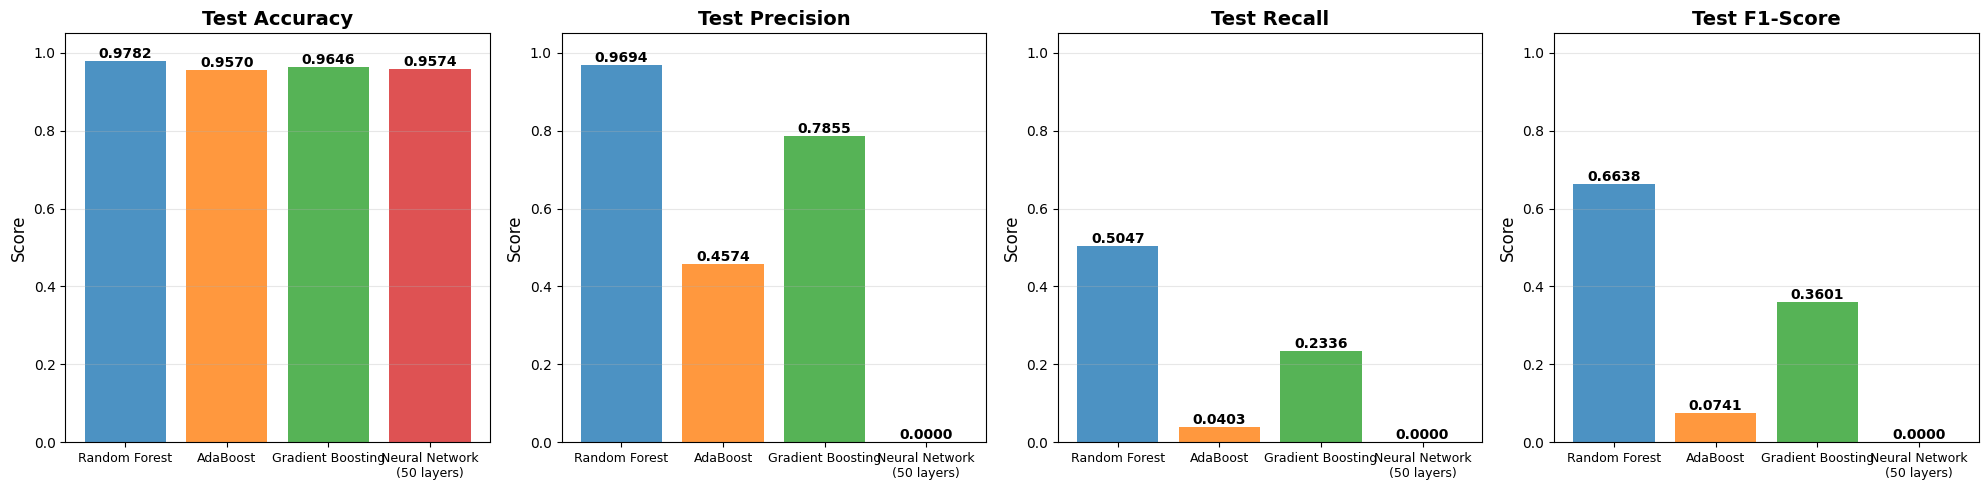

In [36]:
# Additional Visualization 1: Side-by-side metric comparison
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metric_keys = ['accuracy', 'precision', 'recall', 'f1']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

model_names = list(results.keys())

for idx, (metric, metric_key) in enumerate(zip(metrics, metric_keys)):
    test_scores = [results[model][f'test_{metric_key}'] for model in model_names]
    
    bars = axes[idx].bar(range(len(model_names)), test_scores, color=colors, alpha=0.8)
    axes[idx].set_title(f'Test {metric}', fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('Score', fontsize=12)
    axes[idx].set_xticks(range(len(model_names)))
    axes[idx].set_xticklabels([name.replace(' (50 layers)', '\n(50 layers)') for name in model_names], 
                                rotation=0, ha='center', fontsize=9)
    axes[idx].set_ylim([0, 1.05])
    axes[idx].grid(alpha=0.3, axis='y')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

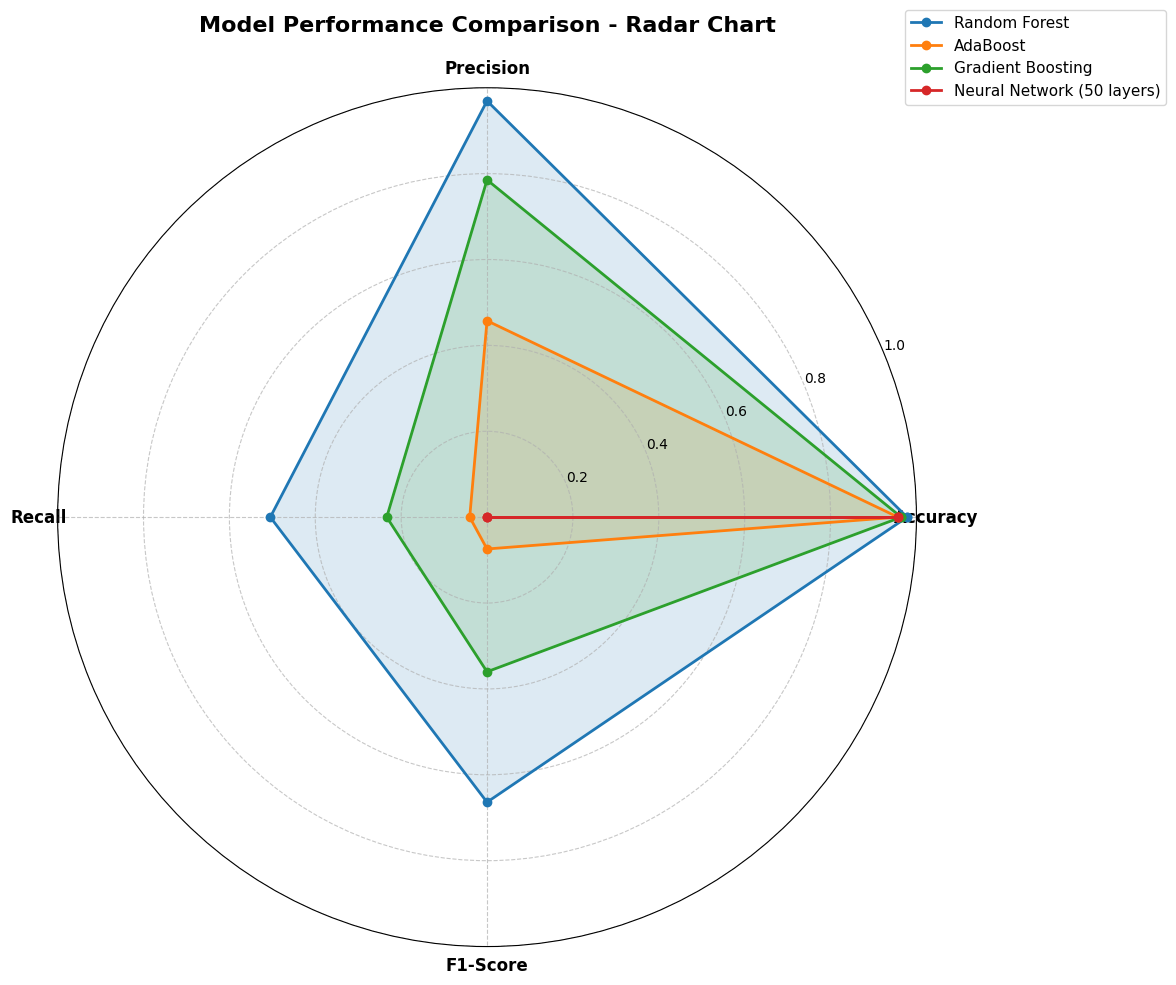

In [37]:
# Additional Visualization 2: Radar chart comparing all models
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

categories = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
num_vars = len(categories)

# Compute angle for each axis
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Plot data for each model
for idx, (model_name, model_data) in enumerate(results.items()):
    values = [
        model_data['test_accuracy'],
        model_data['test_precision'],
        model_data['test_recall'],
        model_data['test_f1']
    ]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[idx])
    ax.fill(angles, values, alpha=0.15, color=colors[idx])

# Set category labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=12, fontweight='bold')

# Set y-axis limits and labels
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=10)
ax.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
plt.title('Model Performance Comparison - Radar Chart', size=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

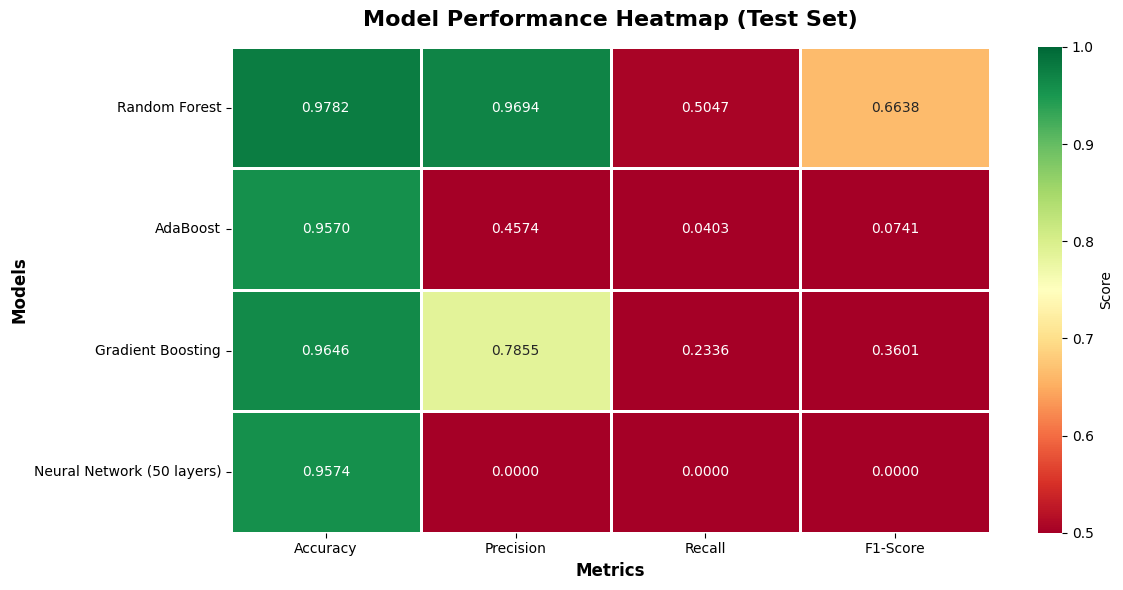

In [38]:
# Additional Visualization 3: Heatmap of all metrics
fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for heatmap
heatmap_data = []
model_names = []
for model_name, model_data in results.items():
    model_names.append(model_name)
    heatmap_data.append([
        model_data['test_accuracy'],
        model_data['test_precision'],
        model_data['test_recall'],
        model_data['test_f1']
    ])

heatmap_df = pd.DataFrame(heatmap_data, 
                            columns=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                            index=model_names)

sns.heatmap(heatmap_df, annot=True, fmt='.4f', cmap='RdYlGn', 
            vmin=0.5, vmax=1.0, center=0.75,
            linewidths=2, linecolor='white',
            cbar_kws={'label': 'Score'},
            ax=ax)

ax.set_title('Model Performance Heatmap (Test Set)', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Models', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

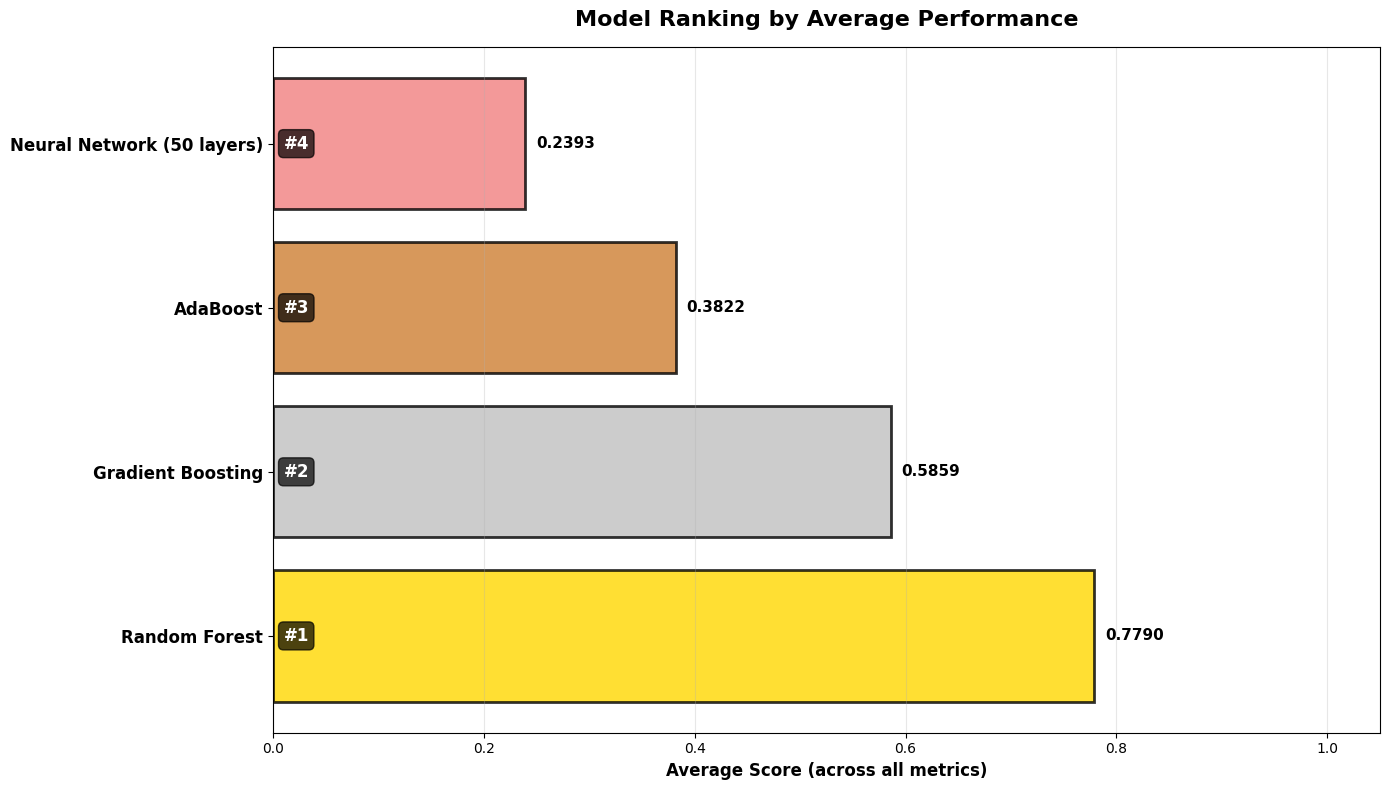


MODEL RANKING
#1: Random Forest                  - Average Score: 0.7790
#2: Gradient Boosting              - Average Score: 0.5859
#3: AdaBoost                       - Average Score: 0.3822
#4: Neural Network (50 layers)     - Average Score: 0.2393


In [39]:
# Additional Visualization 4: Model ranking
fig, ax = plt.subplots(figsize=(14, 8))

# Calculate average performance across all metrics
model_avg_scores = {}
for model_name, model_data in results.items():
    avg_score = (model_data['test_accuracy'] + 
                model_data['test_precision'] + 
                model_data['test_recall'] + 
                model_data['test_f1']) / 4
    model_avg_scores[model_name] = avg_score

# Sort models by average score
sorted_models = sorted(model_avg_scores.items(), key=lambda x: x[1], reverse=True)
model_names_sorted = [item[0] for item in sorted_models]
avg_scores = [item[1] for item in sorted_models]

# Create bar chart
bars = ax.barh(range(len(model_names_sorted)), avg_scores, 
                color=['gold', 'silver', '#CD7F32', 'lightcoral'][:len(model_names_sorted)],
                alpha=0.8, edgecolor='black', linewidth=2)

ax.set_yticks(range(len(model_names_sorted)))
ax.set_yticklabels(model_names_sorted, fontsize=12, fontweight='bold')
ax.set_xlabel('Average Score (across all metrics)', fontsize=12, fontweight='bold')
ax.set_title('Model Ranking by Average Performance', fontsize=16, fontweight='bold', pad=15)
ax.set_xlim([0, 1.05])
ax.grid(alpha=0.3, axis='x')

# Add value labels and ranking
for idx, (bar, score) in enumerate(zip(bars, avg_scores)):
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2.,
            f'{score:.4f}', ha='left', va='center', fontsize=11, fontweight='bold')
    ax.text(0.01, bar.get_y() + bar.get_height()/2.,
            f'#{idx+1}', ha='left', va='center', fontsize=12, fontweight='bold', color='white',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("MODEL RANKING")
print("="*80)
for idx, (model_name, score) in enumerate(sorted_models, 1):
    print(f"#{idx}: {model_name:<30} - Average Score: {score:.4f}")